#A Comparative Analysis of Deep Convolutional Networks for Traffic Sign Recognition

Autonomous driving and advanced driver assistance systems (ADAS) depend heavily on the ability to recognize traffic signs. By providing vital information like speed limits, dangers, and instructions, traffic signs help cars drive safely and in accordance with the law. Creating precise and effective traffic sign recognition systems is essential for maintaining road safety and compliance as the significance of autonomous cars grows.

This project focuses on comparing the performance of various deep neural network architectures, including CNNs, VGGNet, ResNet and EfficientNet, on the German Traffic Sign Recognition Benchmark (GTSRB) dataset. By leveraging state-of-the-art methods and rigorous evaluation, this study aims to contribute to advancements in traffic sign recognition for autonomous systems.

In this notebook, all the best models will be trained for more epochs, evaluated on the test data. This notebook includes Explanatory Data Analysis(EDA). This notebook will be divided into 2 parts.
- Part 1: Train the model on the real data **(Imbalanced data)**.
- Part 2: Train the model on the oversampled data **(Balanced data)**.

#Mount Google Drive and import libraries

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dataset

The German Traffic Sign Recognition Benchmark (GTSRB) dataset will be used in this study. The GTSRB is a widely recognized benchmark in Traffic Sign Recognition(TSR) field, provides a robust platform for developing and testing TSR models. It includes a diverse set of traffic signs captured in various real-world conditions such as lighting, weather, angles, and scales, as well as partial occlusions which make this dataset more reliable.

##Load the dataset

Dataset will be loaded in the next cell. Size of the images in this dataset varies between 15x15 to 250x250 pixels, so **image resize** will be applied to get all the images in same size to avoid biases or inconsistencies in feature map.

**Normalization** is applied to ensure consistent input data, leading to better and more reliable model performance.

**One-hot encoding** is applied to the labels to convert categorical labels into a numerical format that machine learning models can process effectively.

In [2]:
# Define paths to dataset directories
train_data_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_data_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define constants
IMG_SIZE = 32       # Resize images
num_classes = 43    # dataset represents 43 classes

# Define function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Image file extensions
    img_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory that corresponds to a class
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in img_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays and normalize
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes)  # One-hot encode labels

    return images, labels

# Load training data
images, labels = load_data(train_data_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

##Print the total number of images and image size in the dataset.

In [3]:
# Store the images and labels in two new folders
train_images, train_labels = images, labels

# Print dataset shape
print(f'train_images shape: {train_images.shape}')
print(f'train_labels shape: {train_labels.shape}')

train_images shape: (39209, 32, 32, 3)
train_labels shape: (39209, 43)


It is observed that all the images are resized to **32x32x3** pixels and the training set consists of **39,209** images in total.

##Visualize the class distribution of the dataset

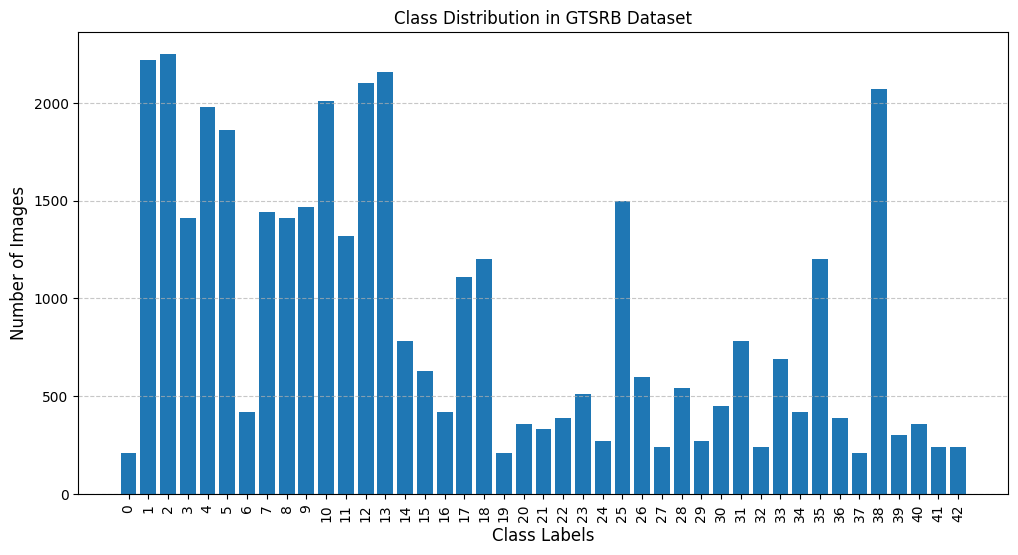

<Figure size 640x480 with 0 Axes>

In [5]:
# Define function to plot class distribution
def plot_class_distribution(train_labels, num_classes):

    # Decode one-hot encoded labels
    class_indices = np.argmax(train_labels, axis=1)

    # Count the samples of each class
    class_counts = np.bincount(class_indices, minlength=num_classes)

    # Plot the class distribution
    plt.figure(figsize=(12, 6))
    plt.bar(range(num_classes), class_counts)
    plt.title('Class Distribution in GTSRB Dataset', fontsize=12)
    plt.xlabel('Class Labels', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(range(num_classes), range(num_classes), rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    plt.savefig('class_distribution.png', dpi = 300)

# Visualize class distribution of the training data
plot_class_distribution(train_labels, num_classes)

The dataset is found to be significantly **imbalanced**. For now in part 1, imbalanced dataset will be used to train the model. Later in part 2, oversampling method (SMOTE) will be applied to balance the dataset and then the model will be trained on balanced dataset.

##Pixel Intensity Distribution
The images have been normalized, as expected in most deep learning applications, so it’s useful to check the distribution of pixel intensities to ensure that the normalization was applied correctly.

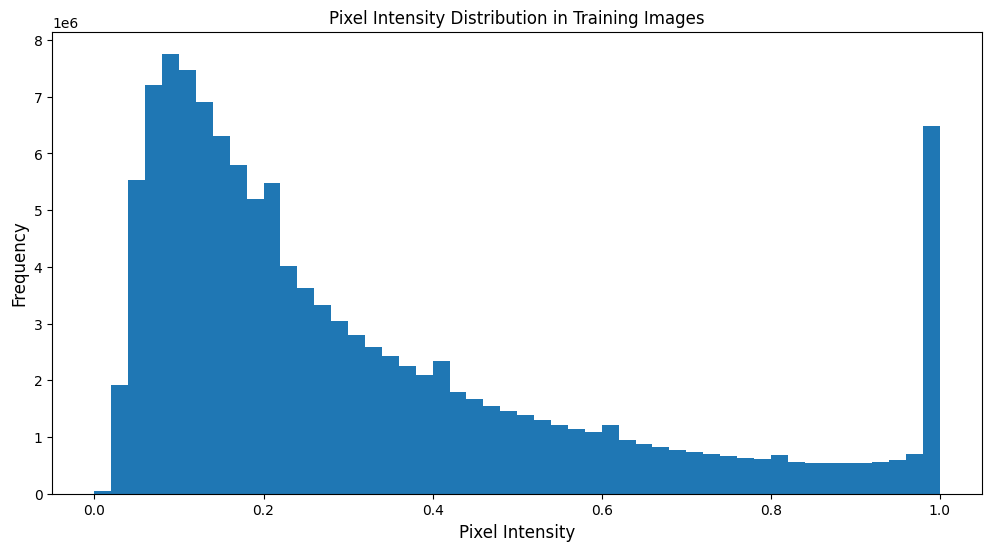

In [6]:
# Define pixel intensity distribution function
def pixel_intensity_distribution(train_images):
    pixel_values = train_images.ravel()  # Flatten the pixel values into a 1D array
    plt.figure(figsize=(12, 6))
    plt.hist(pixel_values, bins=50)
    plt.title('Pixel Intensity Distribution in Training Images', fontsize=12)
    plt.xlabel('Pixel Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

# Call the function
pixel_intensity_distribution(train_images)

The plot says that all the pixel values are in between 0 to 1. It proves that normalization was applied correctly.

##Visualize some images from the dataset
Some sample images will be visualized from the dataset along with their class labels.




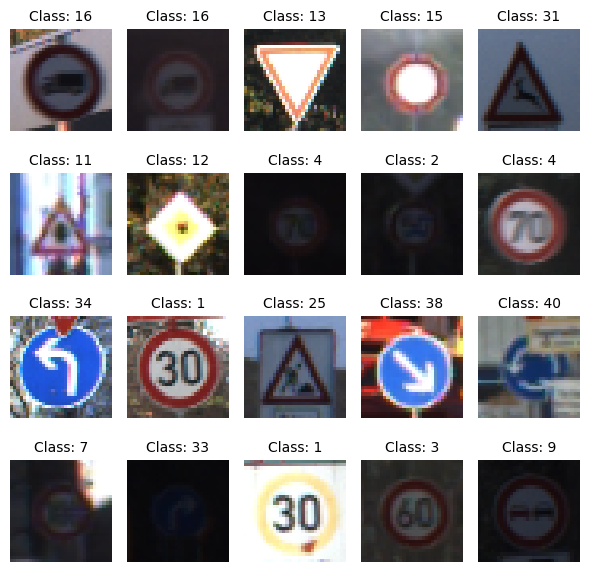

<Figure size 640x480 with 0 Axes>

In [7]:
# Define function to visualize image
def visualize_random_images(train_images, train_labels, num_images=20):
    plt.figure(figsize=(6, 6))
    # Decode one-hot encoded labels
    class_indices = np.argmax(train_labels, axis=1)
    for i in range(num_images):
        plt.subplot(4, 5, i + 1)
        random_idx = np.random.randint(0, len(train_images))  # Pick a random image index
        plt.imshow(cv2.cvtColor(train_images[random_idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.title(f'Class: {class_indices[random_idx]}', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig('sample_images.png', dpi = 300)

# call the function
visualize_random_images(train_images, train_labels)

It can be seen that the photos were taken in a variety of real-world situations, which are related to lighting, weather, and angles.

##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 80% of the dataset will be used for training, and the remaining 20% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [8]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (31367, 32, 32, 3)
y_train shape: (31367, 43)
X_val shape: (7842, 32, 32, 3)
y_val shape: (7842, 43)


##Class Balance in Training and Validation Sets
When we split the dataset into training and validation sets, it's important to ensure that the class distribution is maintained in both subsets. We can plot the distribution of classes in both sets to verify this.

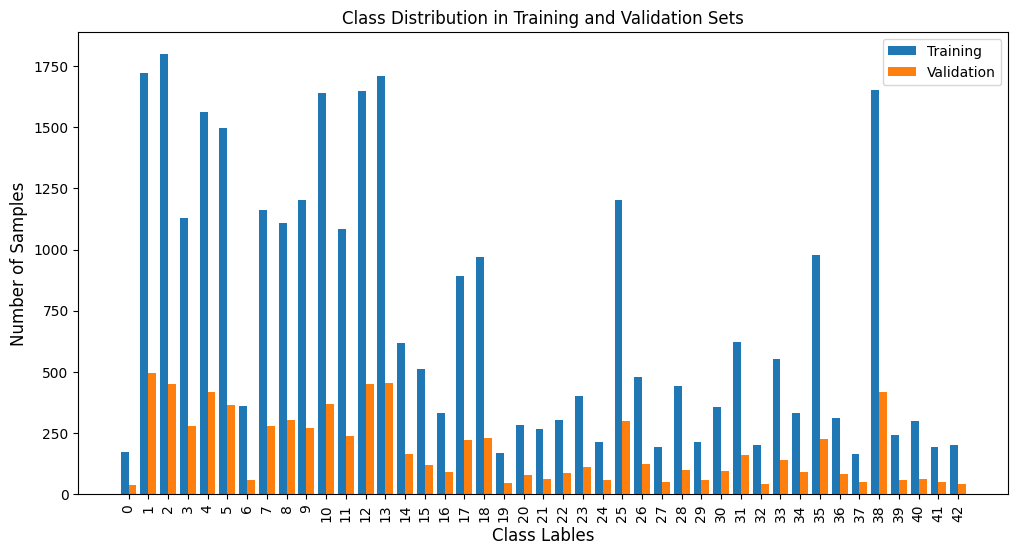

<Figure size 640x480 with 0 Axes>

In [9]:
# Count the number of samples per class
train_class_distribution = np.sum(y_train, axis=0)  # Summing one-hot encoded labels
val_class_distribution = np.sum(y_val, axis=0)

# Define class indices
class_indices = np.arange(len(train_class_distribution))

# Plot class distribution
plt.figure(figsize=(12, 6))

# Plot training class distribution
plt.bar(class_indices - 0.2, train_class_distribution, width=0.4, label='Training')

# Plot validation class distribution
plt.bar(class_indices + 0.2, val_class_distribution, width=0.4, label='Validation')

# Add labels and title
plt.xlabel('Class Lables', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in Training and Validation Sets', fontsize=12)
plt.xticks(class_indices, rotation=90)  # Set x-axis to show class indices
plt.legend()
plt.show()

plt.savefig('class_distribution_train_val_set.png', dpi = 300)

##Load test data

In [10]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # image file extensions
    img_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in img_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32') / 255.0  # Normalize images

    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_data_dir)

Skipping non-image file: GT-final_test.test.csv


##Total Number of images in the test data

In [11]:
# print X_test shape
print(f'X_test shape: {X_test.shape}')

X_test shape: (12630, 32, 32, 3)


##Load ground truth

In [12]:
# Load the ground truth file (downloaded separately)
ground_truth = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

#Define functions

##Function to create the CNN model

In [13]:
from tensorflow.keras import layers, models

# Define a function to create model
def create_cnn_model(input_shape):

  """
  This function will create a CNN model.
  It will accept input shape as a parameter.
  """

  # Build a simple CNN model
  model = models.Sequential()

  # Convolutional layer
  model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
  model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1))

  # Add more layers
  model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(rate=0.5))

  model.add(layers.Dense(num_classes, activation='softmax'))

  return model

# call create model function
model = create_cnn_model((IMG_SIZE,IMG_SIZE, 3))

# print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,761,099 (6.72 MB)

 Trainable params: 1,759,755 (6.71 MB)

 Non-trainable params: 1,344 (5.25 KB)

##Function to create the best vgg16 model

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# write a function to load best vgg16 model
def load_vgg16_model_4_conv_layer(input_shape):

    """
    This function will load vgg16 model with its first 4
    convolution layers as trainable along with the top layers.
    It will accept input shape as parameter.
    """
    # Load the VGG16 base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

    # Add new layers on top of the base model
    model = Sequential()
    model.add(base_model)

    # Continue with custom layers
    x = base_model.get_layer('block2_pool').output # this layer give the best result along with top layers for GTSRB dataset.
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='sigmoid')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs = base_model.input, outputs = out, name='model')

    # Train all layers
    for layer in model.layers:
        layer.trainable = True

    return model

# Call the function
model = load_vgg16_model_4_conv_layer((IMG_SIZE, IMG_SIZE, 3))

# Print model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,477,547 (17.08 MB)

 Trainable params: 4,477,291 (17.08 MB)

 Non-trainable params: 256 (1.00 KB)

##Function to create the best ResNet50 model

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# write a function to load best ResNet50 model
def load_ResNet50_model_8_conv_layer(input_shape):

    """
    This function will load the best ResNet50 model with its first 8
    convolutional layers as trainable along with it's top layers.
    It will accept input shape as parameter.
    """

    # Load the ResNet50 base model
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Add new layers on top of the base model
    model = Sequential()
    model.add(base_model)

    # Continue with custom layers
    x = base_model.get_layer('conv2_block2_out').output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='sigmoid')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs = base_model.input, outputs = out, name='model')

    return model

# Call the function
model = load_ResNet50_model_8_conv_layer((IMG_SIZE, IMG_SIZE, 3))

# Print model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 8,570,411 (32.69 MB)

 Trainable params: 8,567,723 (32.68 MB)

 Non-trainable params: 2,688 (10.50 KB)

##Function to create the best EfficientNetB0 model

In [16]:
from tensorflow.keras.applications import EfficientNetB0

# write a function to load best EfficientNetB0 model
def load_EfficientNetB0_model_block3a_project_conv(input_shape):

    """
    This function will load EfficientNetB0 model with
    stem_conv, block1, block2 and block3 layers and top layers
    It will accept input shape as parameter
    """

    # Load the EfficientNetB0 base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Add new layers on top of the base model
    model = Sequential()
    model.add(base_model)

    # Continue with custom layers
    x = base_model.get_layer('block3a_project_conv').output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='sigmoid')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs = base_model.input, outputs = out, name='model')

    return model

# Call the function
model = load_EfficientNetB0_model_block3a_project_conv((IMG_SIZE, IMG_SIZE, 3))

# Print model summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 32, 32, 3)      │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 32, 32, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 386,570 (1.47 MB)

 Trainable params: 384,691 (1.47 MB)

 Non-trainable params: 1,879 (7.34 KB)

The non-trainable parameters in the models come from the BatchNormalization layer. During training, BatchNormalization computes and updates mean and variance. These are updated during training but are not modified during backpropagation. This is why they are non-trainable.

## Function to compile and train model

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# define a function to train the best models
def train_model(model, lr, BATCH_SIZE, EPOCHS):
    """
    This function will train the model.
    Parameters:
        model: the model that will be trained
        lr: learning rate
        BATCH_SIZE: batch size
        EPOCHS: number of epochs
    """
    # Initialize EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        callbacks=[early_stopping]
    )

    return history

## Function to plot accuracy and loss curve
A function will be created to visualize the accuracy and loss curve of the models across the epochs.

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# set style
sns.set_style('whitegrid')

# write a function to visualize curves
def visualize_training_curves(history):

    """
    This function will plot the accuracy and loss curve of the trained model.
    parameter:
        history: It contains training history of the model
    """

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Plot accuracy with y-axis [0, 1]
    axes[0, 0].plot(history.history['accuracy'], label='train_accuracy', color="blue")
    axes[0, 0].plot(history.history['val_accuracy'], label='val_accuracy', color="orange")
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_ylabel('Accuracy (y-axis 0 to 1.05)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylim(0, 1.05)
    axes[0, 0].legend(loc='lower right')
    axes[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    # Plot accuracy
    axes[0, 1].plot(history.history['accuracy'], label='train_accuracy', color="blue")
    axes[0, 1].plot(history.history['val_accuracy'], label='val_accuracy', color="orange")
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(loc='lower right')
    axes[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    # Plot loss
    axes[1, 0].plot(history.history['loss'], label='train_loss', color="green")
    axes[1, 0].plot(history.history['val_loss'], label='val_loss', color="red")
    axes[1, 0].set_title('Model Loss')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend(loc='upper right')
    axes[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    # Plot accuracy and loss
    axes[1, 1].plot(history.history['accuracy'], label='train_accuracy', color="blue")
    axes[1, 1].plot(history.history['val_accuracy'], label='val_accuracy', color="orange")
    axes[1, 1].plot(history.history['loss'], label='train_loss', color="green")
    axes[1, 1].plot(history.history['val_loss'], label='val_loss', color="red")
    axes[1, 1].set_title('Model Performance')
    axes[1, 1].set_ylabel('Accuracy and Loss (y-axis 0 to 1.05)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylim(0, 1.05)
    axes[1, 1].legend(loc='upper right')
    axes[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    # Adjust layout
    plt.tight_layout()
    plt.show()

#Part 1: Train the model on the real data (Imbalanced data).

#Train the best CNN model

Training the best CNN model.
Epoch 1/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7692 - loss: 0.9287 - val_accuracy: 0.9871 - val_loss: 0.0534
Epoch 2/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9830 - loss: 0.0590 - val_accuracy: 0.9833 - val_loss: 0.0509
Epoch 3/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9709 - loss: 0.0960 - val_accuracy: 0.9866 - val_loss: 0.0520
Epoch 4/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9909 - loss: 0.0287 - val_accuracy: 0.9943 - val_loss: 0.0210
Epoch 5/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9915 - loss: 0.0273 - val_accuracy: 0.9893 - val_loss: 0.0408
Epoch 6/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9906 - loss: 0.0299 - val_accuracy: 0.9911 - val_loss: 0.0335
Epoch 7/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9903 - loss: 0.0321 - val_accuracy: 0.9929 - val_loss: 0.0278
Epoch 8/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - ac

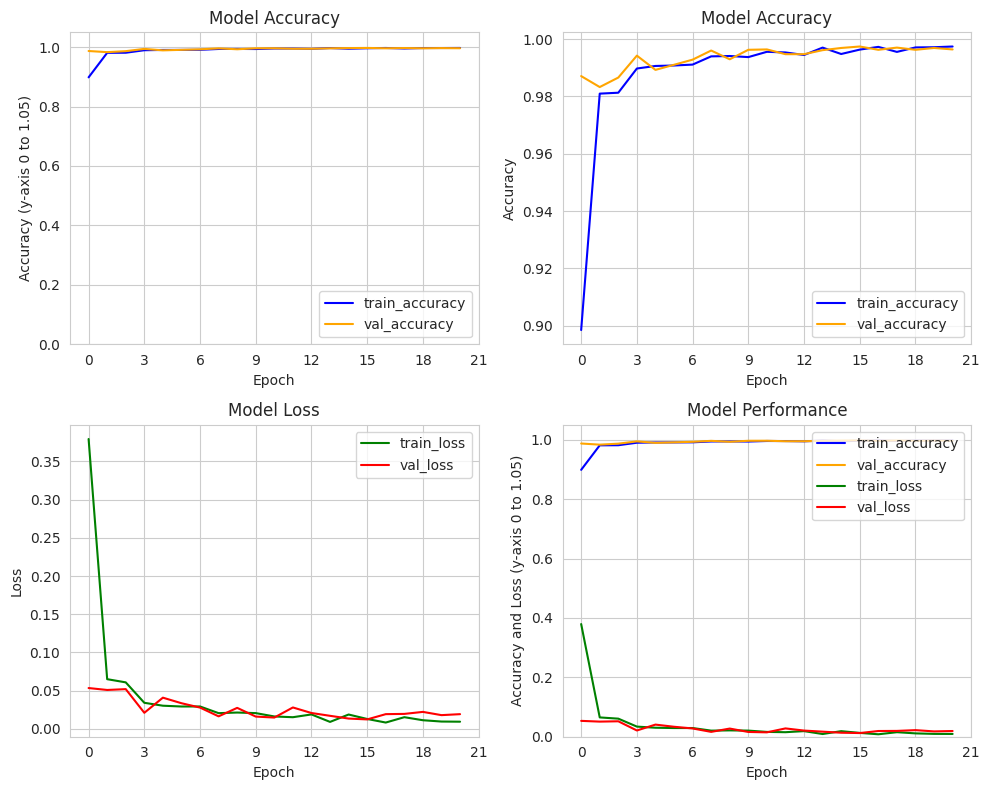

In [ ]:
# Set best parameters for cnn model
lr = 0.001
BATCH_SIZE = 16
EPOCHS = 50

print(f'Training the best CNN model.')
# Call create model Function
model = create_cnn_model((IMG_SIZE,IMG_SIZE, 3))

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

##Evaluate the model on test data (Unseen data)

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Save predicted classes and the image file names to a dataframe
predictions_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
predictions_df = predictions_df.sort_values(by='Filename')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Best CNN Model Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best CNN Model Test Accuracy: 98.11%


##Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:\n", classification_report(merged_df['ClassId'], merged_df['Predicted Class']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class']))

# Get the classification report as a dictionary
report_dict = classification_report(merged_df['ClassId'], merged_df['Predicted Class'], output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_cnn.csv', index=True)

# Save the model
model.save("my_model.h5")

print("Classification report saved as 'classification_report_cnn.csv'")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.97      0.99      0.98       720
           2       0.99      1.00      0.99       750
           3       1.00      0.98      0.99       450
           4       1.00      0.98      0.99       660
           5       0.97      0.99      0.98       630
           6       1.00      0.94      0.97       150
           7       0.98      0.98      0.98       450
           8       0.98      0.98      0.98       450
           9       0.98      1.00      0.99       480
          10       0.99      0.99      0.99       660
          11       0.96      1.00      0.98       420
          12       1.00      0.99      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      0.99      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      0.99      1.00       150
   

##Confusion Matrix

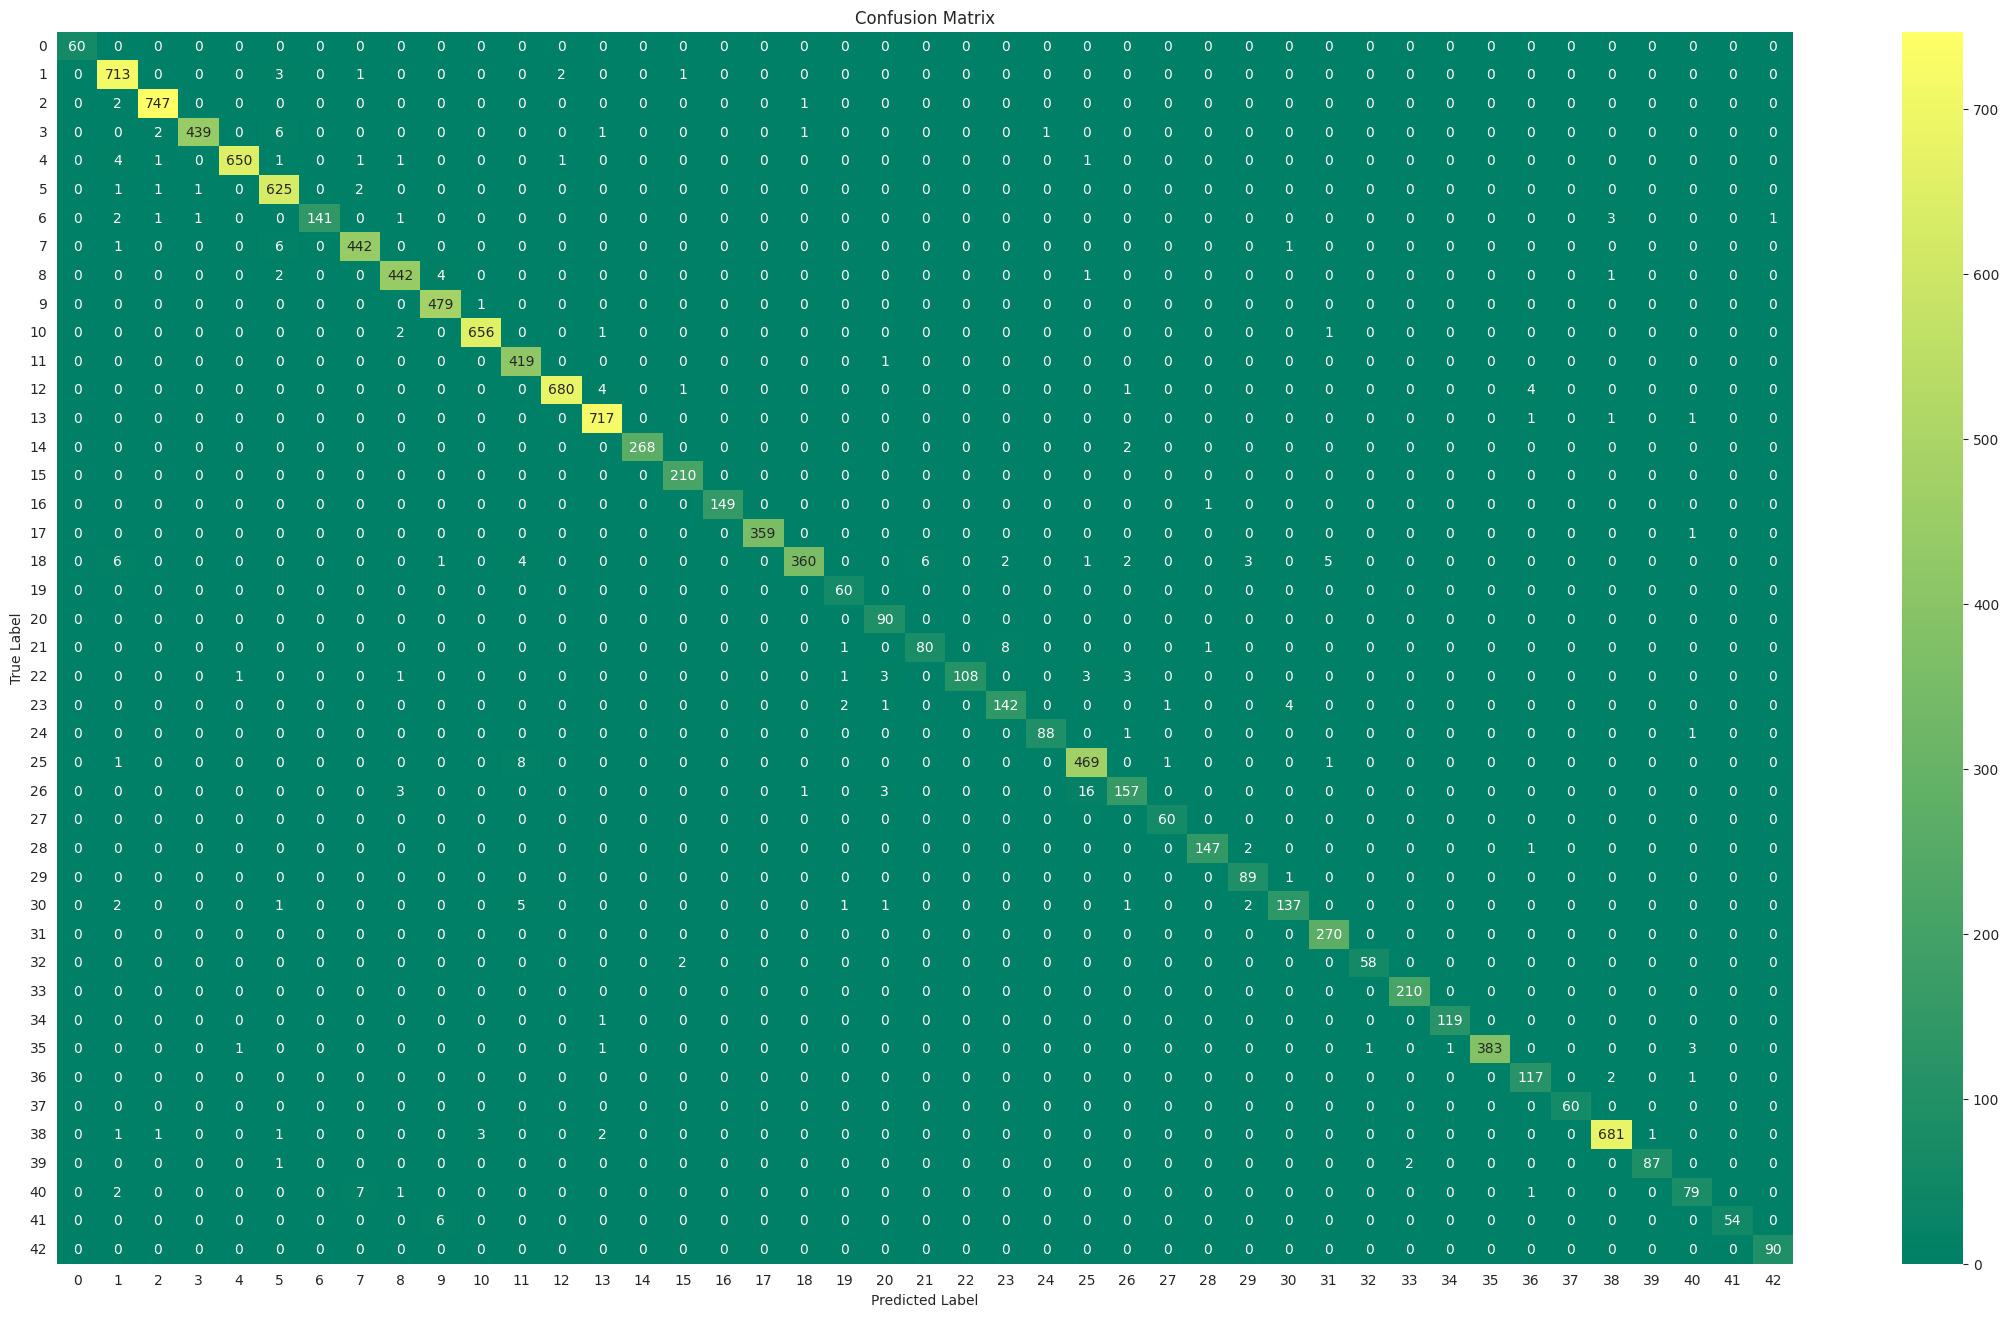

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class'])

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

#Train the best vgg16 model

Training the best vgg16 model.
Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.8367 - loss: 0.6758 - val_accuracy: 0.9881 - val_loss: 0.0990
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9990 - loss: 0.0075 - val_accuracy: 0.9977 - val_loss: 0.0127
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.9992 - val_loss: 0.0045
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9996 - loss: 0.0027 - val_accuracy: 0.9959 - val_loss: 0.0229
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 1.0000 - loss: 2.2948e-04 - val_accuracy: 0.9994 - val_loss: 0.0026
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 1.0000 - loss: 1.4475e-04 - val_accuracy: 0.9995 - val_loss: 0.0024
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - 

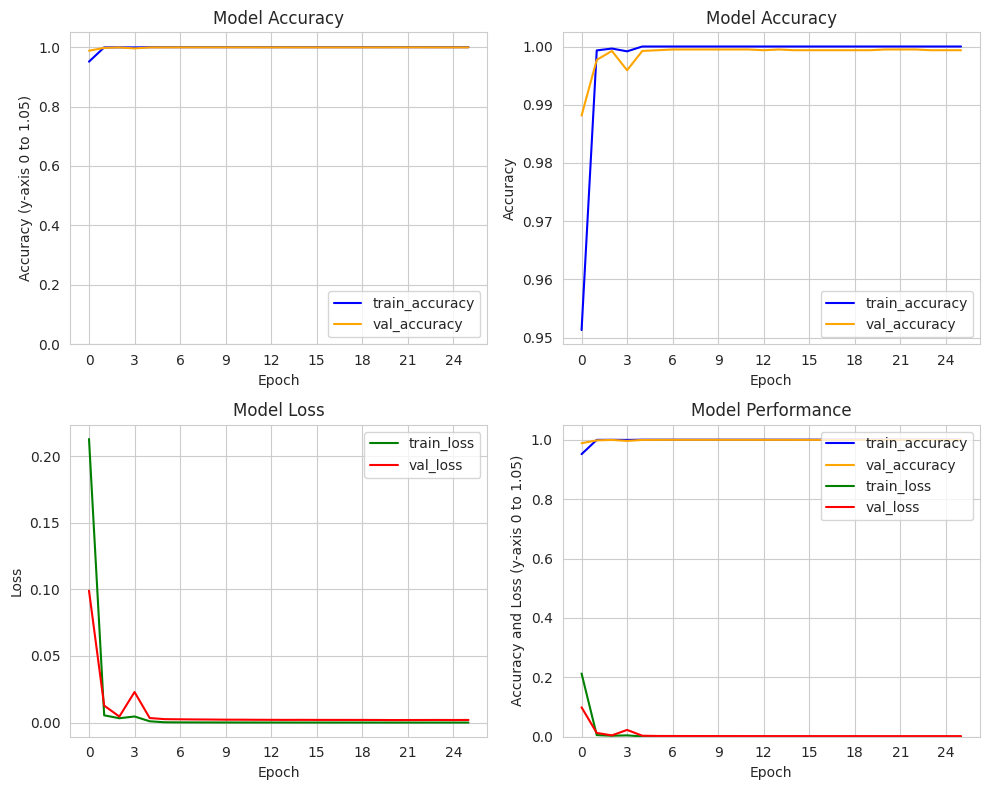

In [ ]:
# Set best parameters for vgg16 model
lr = 0.001
BATCH_SIZE = 128
EPOCHS = 50

print(f'Training the best vgg16 model.')
# Call create model Function
model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

##Evaluate the model on test data (Unseen data)

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Save predicted classes and the image file names to a dataframe
predictions_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
predictions_df = predictions_df.sort_values(by='Filename')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Best vgg16 Model Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Best vgg16 Model Test Accuracy: 98.92%


##Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:\n", classification_report(merged_df['ClassId'], merged_df['Predicted Class']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class']))

# Get the classification report as a dictionary
report_dict = classification_report(merged_df['ClassId'], merged_df['Predicted Class'], output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_vgg16.csv', index=True)

# Save the model
model.save("best_vgg16.h5")

print("Classification report saved as 'classification_report_vgg16.csv'")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      0.99       720
           2       1.00      0.99      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      0.99      1.00       660
           5       0.98      1.00      0.99       630
           6       1.00      0.92      0.96       150
           7       1.00      1.00      1.00       450
           8       0.99      1.00      1.00       450
           9       0.99      1.00      0.99       480
          10       1.00      0.99      1.00       660
          11       0.97      1.00      0.98       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.99       210
          16       1.00      1.00      1.00       150
   

##Confusion Matrix

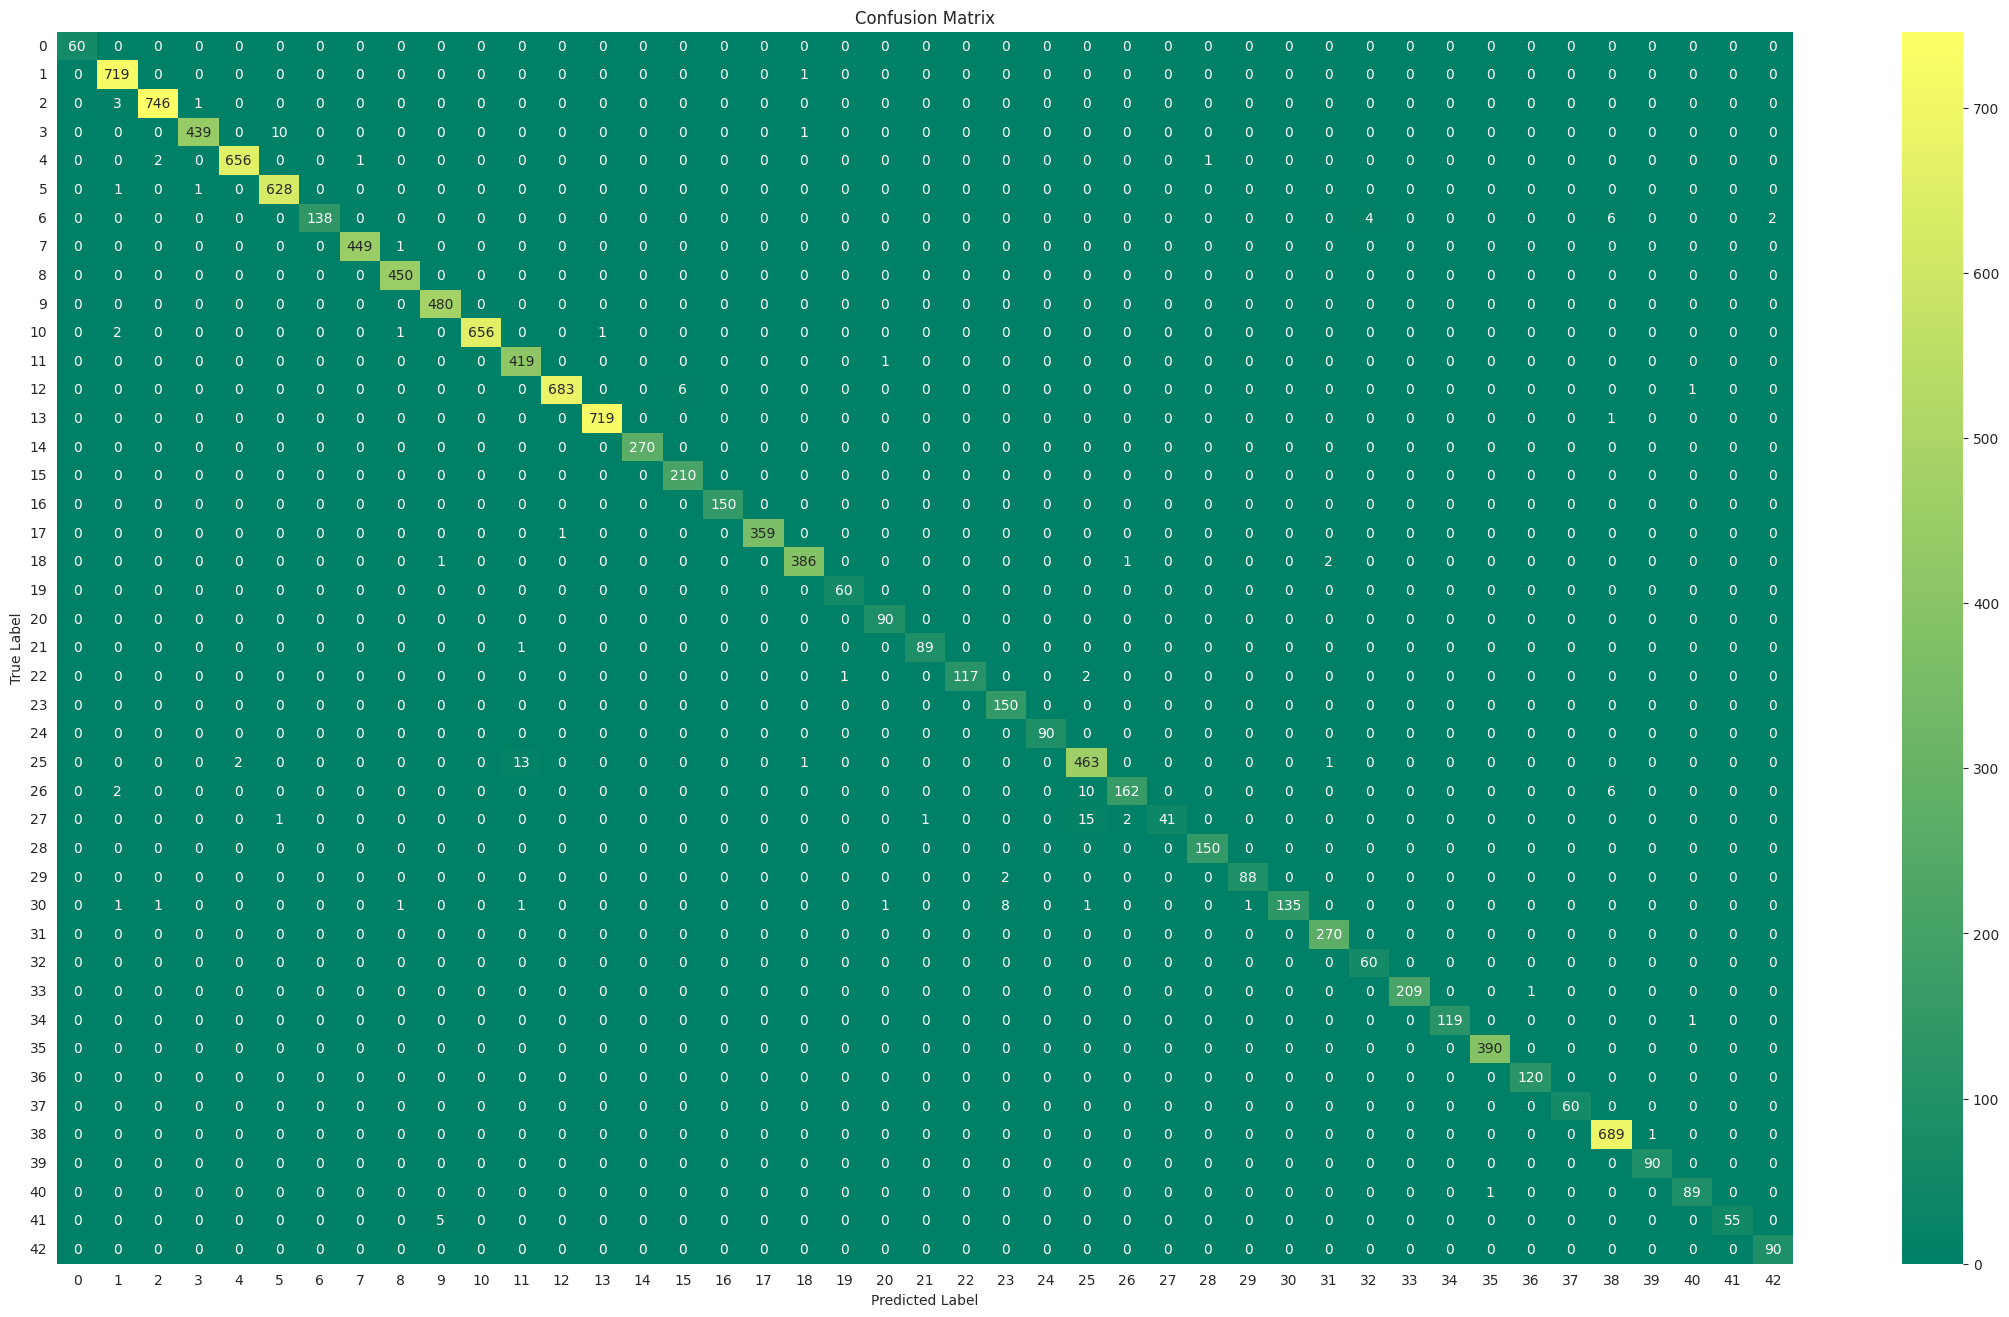

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class'])

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

#Train the best ResNet50 model

Training the best ResNet50 model.
Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.8191 - loss: 0.7593 - val_accuracy: 0.9756 - val_loss: 0.1401
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9971 - loss: 0.0296 - val_accuracy: 0.9960 - val_loss: 0.0245
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9991 - loss: 0.0105 - val_accuracy: 0.9973 - val_loss: 0.0144
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9996 - loss: 0.0050 - val_accuracy: 0.9973 - val_loss: 0.0128
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9977 - val_loss: 0.0088
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9983 - val_loss: 0.0068
Epoch 7/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 1.0000 - loss: 6.4873e-04 - val_accuracy: 0.9985 - val_loss: 0.0060
Epoch 8/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accura

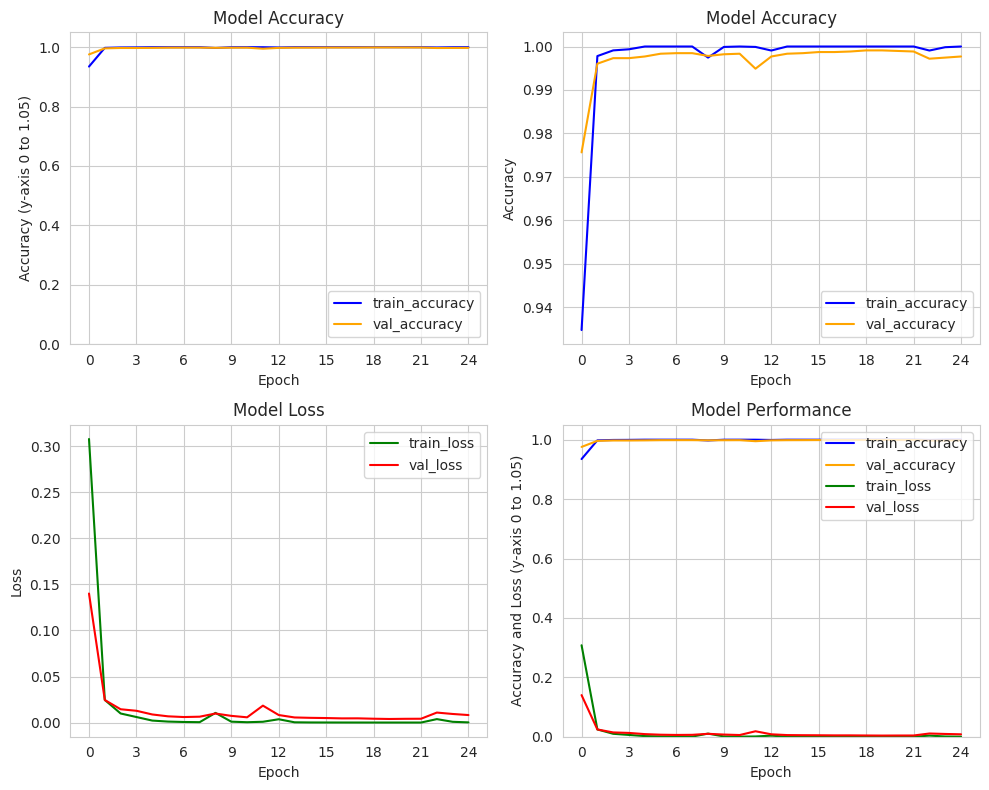

In [ ]:
# Set best parameters
lr = 0.0001
BATCH_SIZE = 32
EPOCHS = 50

print(f'Training the best ResNet50 model.')
# Call create model Function
model = load_ResNet50_model_8_conv_layer((IMG_SIZE,IMG_SIZE, 3))

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

##Evaluate the model on test data (Unseen data)

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Save predicted classes and the image file names to a dataframe
predictions_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
predictions_df = predictions_df.sort_values(by='Filename')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Best ResNet50 Model Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Best ResNet50 Model Test Accuracy: 97.24%


##Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:\n", classification_report(merged_df['ClassId'], merged_df['Predicted Class']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class']))

# Get the classification report as a dictionary
report_dict = classification_report(merged_df['ClassId'], merged_df['Predicted Class'], output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_ResNet50.csv', index=True)

# Save the model
model.save("best_resnet50.h5")

print("Classification report saved as 'classification_report_ResNet50.csv'")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        60
           1       0.97      0.99      0.98       720
           2       0.98      1.00      0.99       750
           3       0.97      0.96      0.97       450
           4       0.99      0.99      0.99       660
           5       0.96      0.98      0.97       630
           6       1.00      0.91      0.95       150
           7       0.99      0.94      0.96       450
           8       0.94      0.98      0.96       450
           9       0.98      0.99      0.99       480
          10       0.99      1.00      0.99       660
          11       0.95      0.95      0.95       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00      1.00       210
          16       1.00      0.99      0.99       150
   

##Confusion Matrix

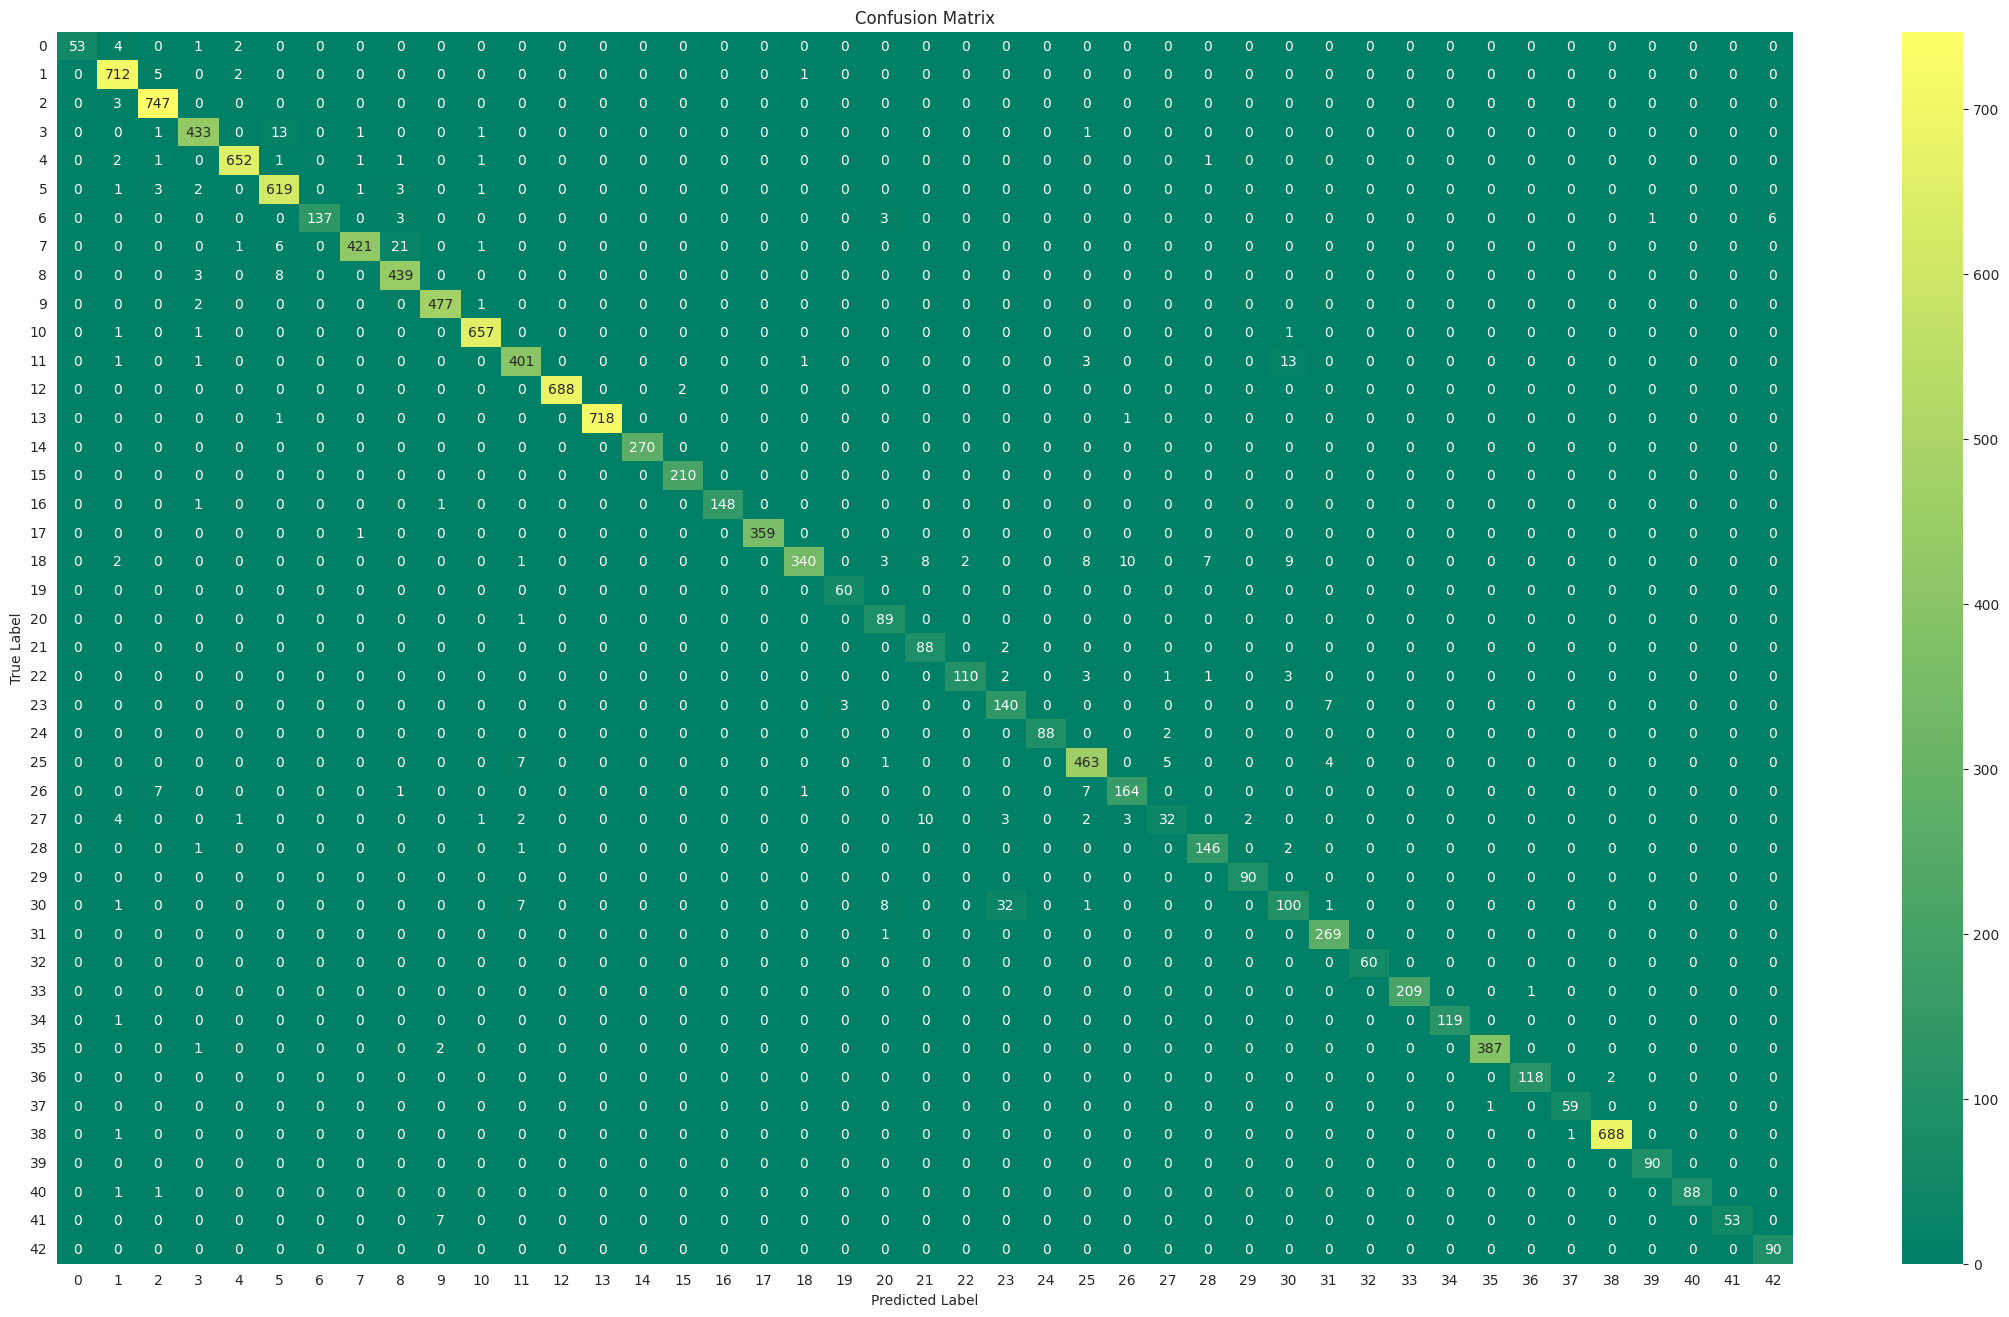

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class'])

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

#Train the best EfficientNetB0 model

Training the best EfficientNetB0 model.
Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.6775 - loss: 1.3472 - val_accuracy: 0.1214 - val_loss: 3.7089
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9929 - loss: 0.0552 - val_accuracy: 0.7529 - val_loss: 0.9277
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9988 - loss: 0.0178 - val_accuracy: 0.9737 - val_loss: 0.0894
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9997 - loss: 0.0084 - val_accuracy: 0.9974 - val_loss: 0.0151
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9998 - loss: 0.0054 - val_accuracy: 0.9974 - val_loss: 0.0116
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.9982 - val_loss: 0.0084
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9998 - loss: 0.0029 - val_accuracy: 0.9985 - val_loss: 0.0077
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - a

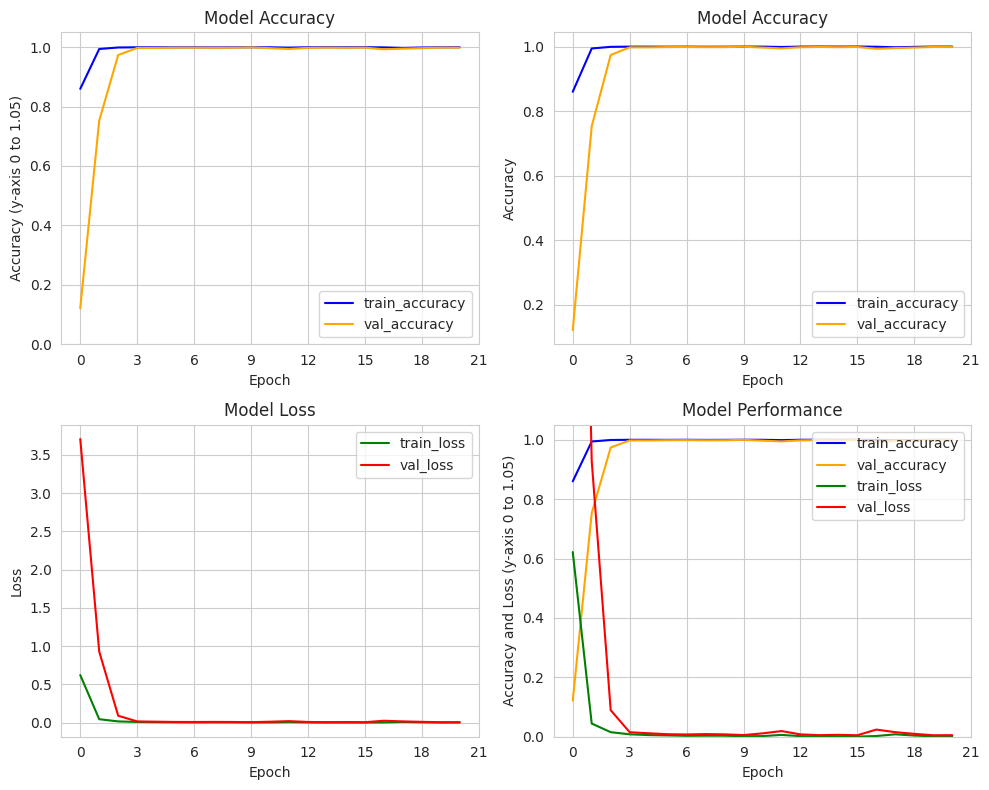

In [ ]:
# Set best parameters
lr = 0.001
BATCH_SIZE = 128
EPOCHS = 50

print(f'Training the best EfficientNetB0 model.')
# Call create model Function
model = load_EfficientNetB0_model_block3a_project_conv((IMG_SIZE,IMG_SIZE, 3))

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

##Evaluate the model on test data (Unseen data)

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Save predicted classes and the image file names to a dataframe
predictions_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
predictions_df = predictions_df.sort_values(by='Filename')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Best EfficientNetB0 Model Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Best EfficientNetB0 Model Test Accuracy: 97.97%


##Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:\n", classification_report(merged_df['ClassId'], merged_df['Predicted Class']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class']))

# Get the classification report as a dictionary
report_dict = classification_report(merged_df['ClassId'], merged_df['Predicted Class'], output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_EfficientNetB0.csv', index=True)

# Save the model
model.save("best_efficientnetb0.h5")

print("Classification report saved as 'classification_report_EfficientNetB0.csv'")

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96        60
           1       0.96      1.00      0.98       720
           2       0.99      0.99      0.99       750
           3       0.98      0.98      0.98       450
           4       0.99      0.99      0.99       660
           5       0.97      0.99      0.98       630
           6       0.99      0.92      0.96       150
           7       1.00      0.96      0.98       450
           8       0.95      0.99      0.97       450
           9       0.98      1.00      0.99       480
          10       1.00      0.99      1.00       660
          11       0.93      0.98      0.95       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      0.99      1.00       150
   

##Confusion Matrix

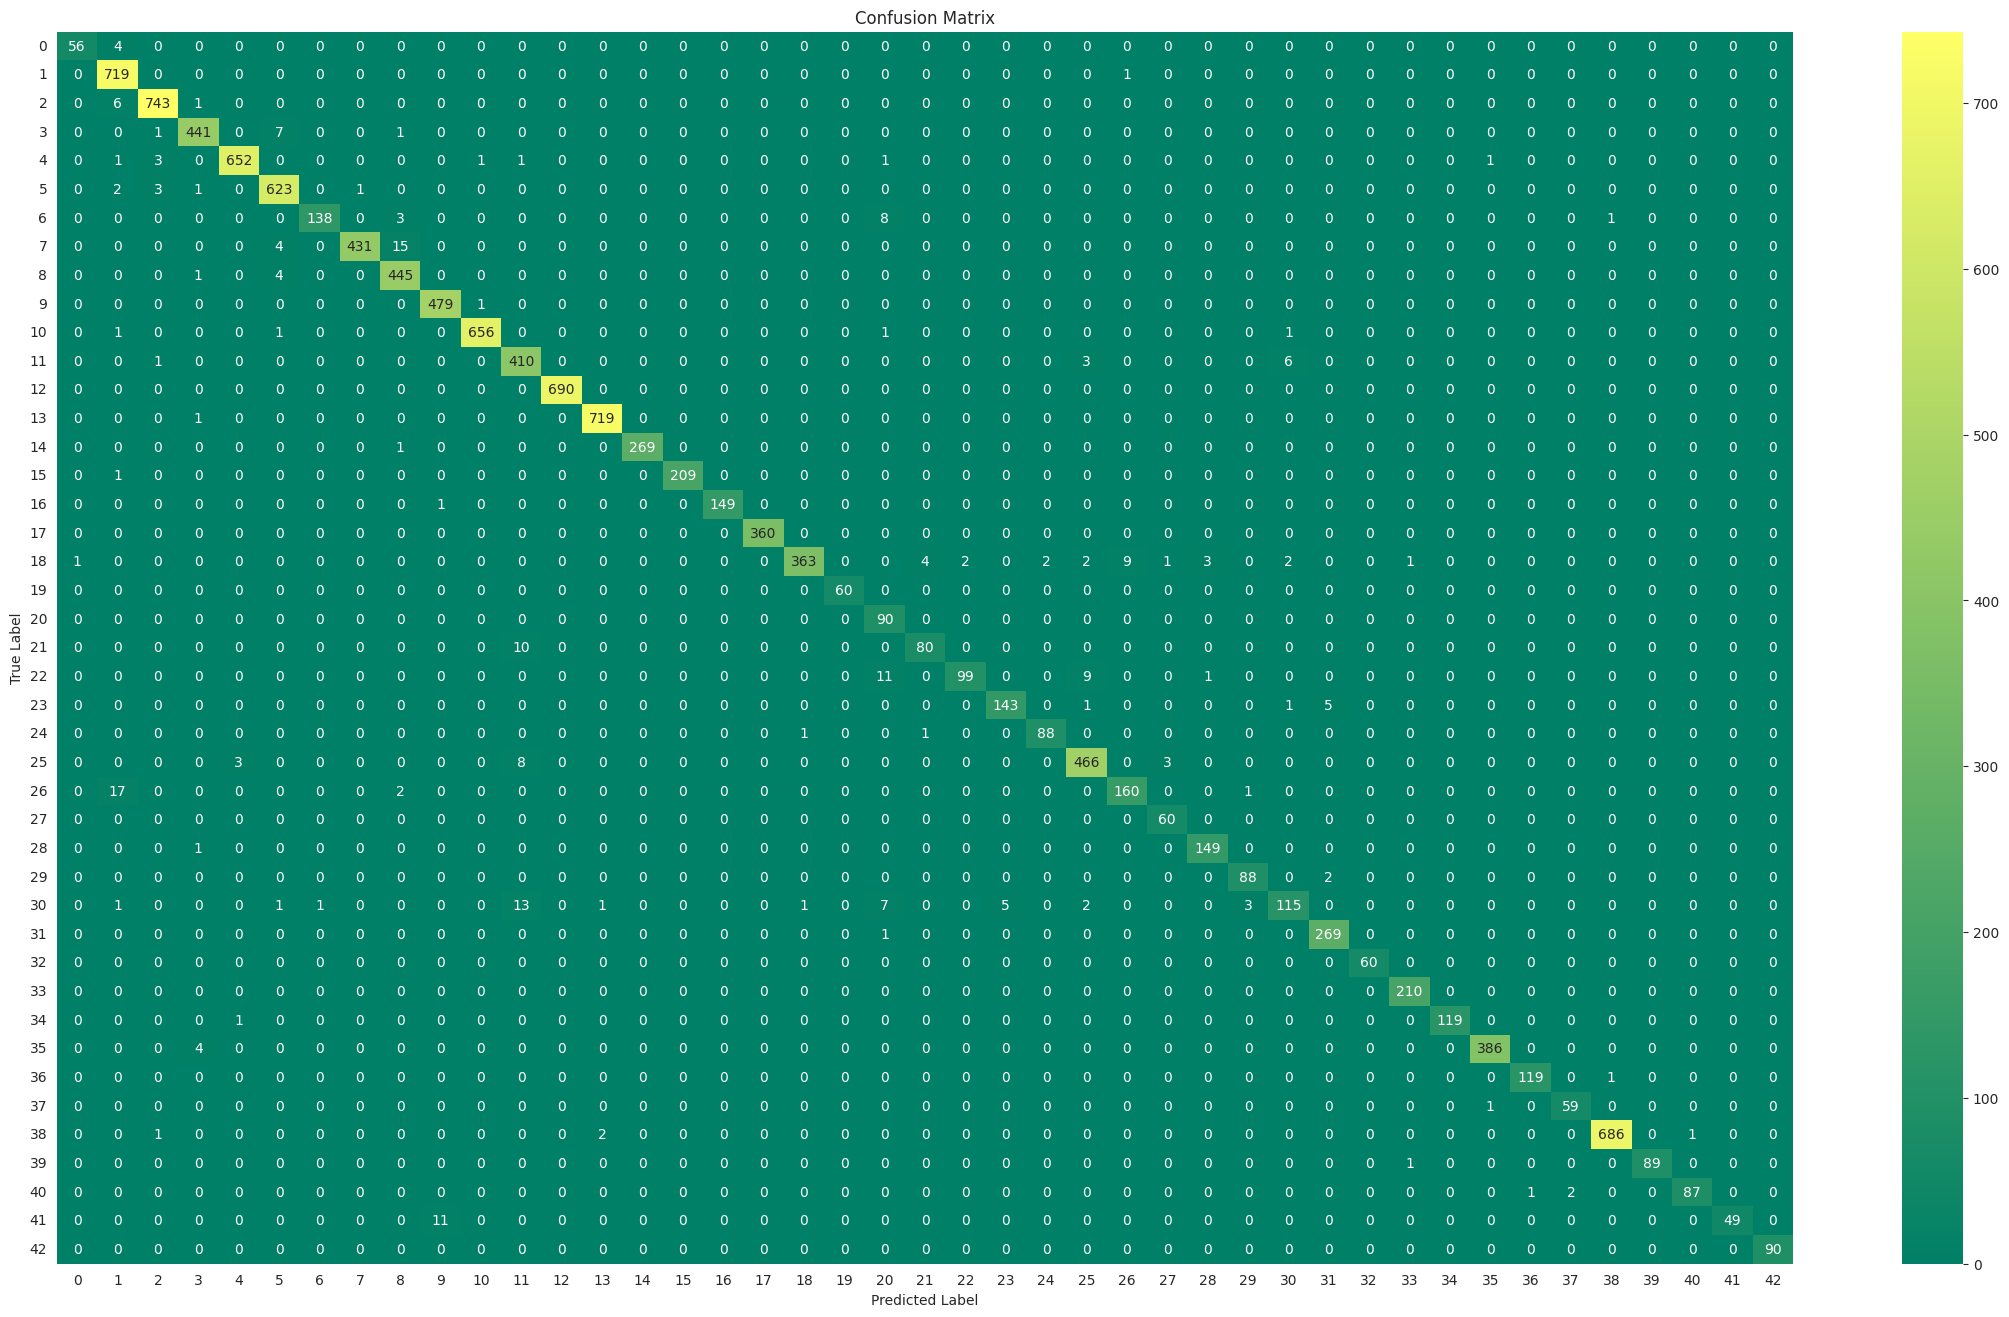

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class'])

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

#Part 2: Train the model on the oversampled data (Balanced data).

## Synthetic Minority Oversampling Technique (SMOTE)

Applying Synthetic Minority Oversampling Technique (SMOTE) to over-sample the classes which are under-represented. This helps balance the dataset and improve the performance of machine learning models, particularly for imbalanced classification tasks.

In [19]:
train_images, train_labels = images, labels

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

train_rows=len(train_images)
train_images = train_images.reshape(train_rows,-1)

train_images, train_labels = sm.fit_resample(train_images, train_labels)
train_images = train_images.reshape(-1,32,32,3)

print(f'Total number of train images and labels after applying SMOTE')
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')

Total number of train images and labels after applying SMOTE
Train images shape: (96750, 32, 32, 3)
Train labels shape: (96750, 43)


##Visualize the class distribution of the dataset after applying SMOTE

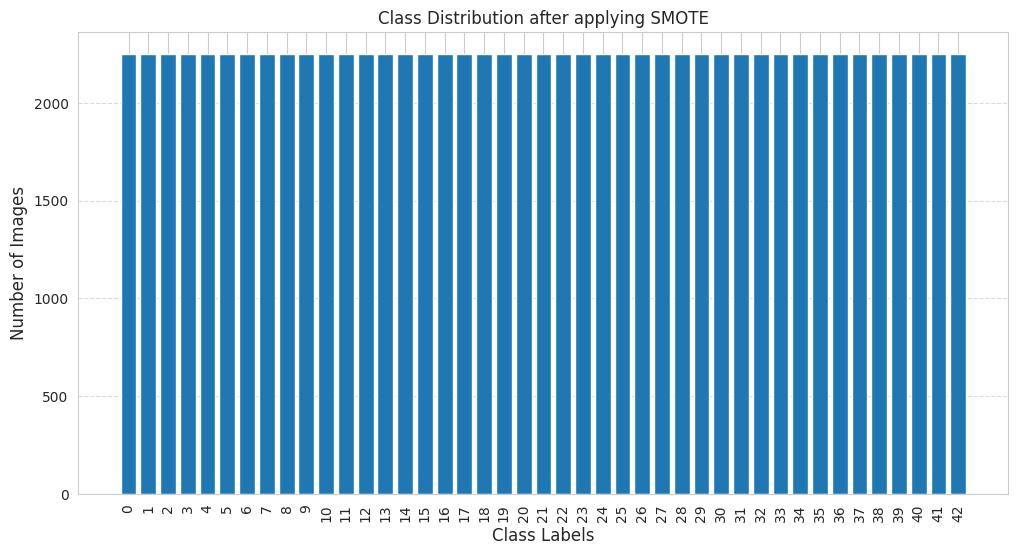

<Figure size 640x480 with 0 Axes>

In [20]:
# Define function to plot class distribution
def plot_class_distribution(train_labels, num_classes):

    # Decode one-hot encoded labels
    class_indices = np.argmax(train_labels, axis=1)

    # Count the samples of each class
    class_counts = np.bincount(class_indices, minlength=num_classes)

    # Plot the class distribution
    plt.figure(figsize=(12, 6))
    plt.bar(range(num_classes), class_counts)
    plt.title('Class Distribution after applying SMOTE', fontsize=12)
    plt.xlabel('Class Labels', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(range(num_classes), range(num_classes), rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    plt.savefig('class_distribution_oversampled_dataset.png', dpi = 300)


# Visualize class distribution of the training data
plot_class_distribution(train_labels, num_classes)


##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 70% of the dataset will be used for training, and the remaining 30% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [21]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (77400, 32, 32, 3)
y_train shape: (77400, 43)
X_val shape: (19350, 32, 32, 3)
y_val shape: (19350, 43)


##Class Balance in Training and Validation Sets
When we split the dataset into training and validation sets, it's important to ensure that the class distribution is maintained in both subsets. We can plot the distribution of classes in both sets to verify this.

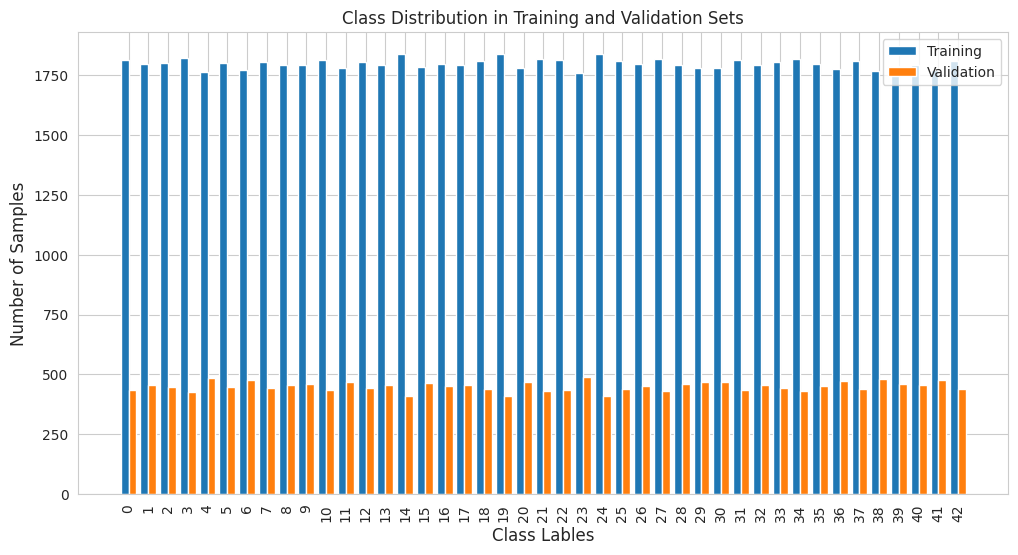

<Figure size 640x480 with 0 Axes>

In [22]:
# Count the number of samples per class
train_class_distribution = np.sum(y_train, axis=0)  # Summing one-hot encoded labels
val_class_distribution = np.sum(y_val, axis=0)

# Define class indices
class_indices = np.arange(len(train_class_distribution))

# Plot class distribution
plt.figure(figsize=(12, 6))

# Plot training class distribution
plt.bar(class_indices - 0.2, train_class_distribution, width=0.4, label='Training')

# Plot validation class distribution
plt.bar(class_indices + 0.2, val_class_distribution, width=0.4, label='Validation')

# Add labels and title
plt.xlabel('Class Lables', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in Training and Validation Sets', fontsize=12)
plt.xticks(class_indices, rotation=90)  # Set x-axis to show class indices
plt.legend()
plt.show()

plt.savefig('class_distribution_oversampled_train_val_set.png', dpi = 300)

#Train the best CNN model

Training the best CNN model on oversampled dataset.
Epoch 1/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8812 - loss: 0.4715 - val_accuracy: 0.9939 - val_loss: 0.0234
Epoch 2/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9887 - loss: 0.0385 - val_accuracy: 0.9850 - val_loss: 0.0776
Epoch 3/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9927 - loss: 0.0254 - val_accuracy: 0.9973 - val_loss: 0.0096
Epoch 4/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9939 - loss: 0.0210 - val_accuracy: 0.9963 - val_loss: 0.0136
Epoch 5/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9960 - loss: 0.0139 - val_accuracy: 0.9984 - val_loss: 0.0082
Epoch 6/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9965 - loss: 0.0125 - val_accuracy: 0.9987 - val_loss: 0.0056
Epoch 7/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9977 - loss: 0.0081 - val_accuracy: 0.9984 - val_loss: 0.0076
Epoch 8/50
4837/4837 ━━━━━━━━━━

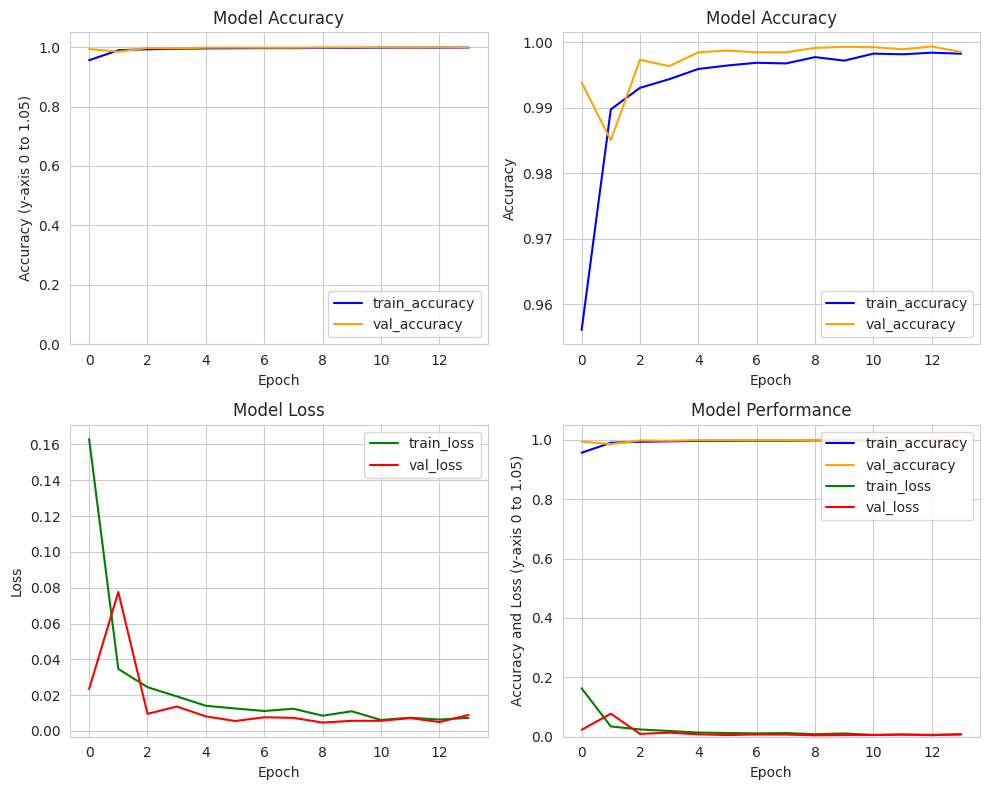

In [25]:
# Set best parameters for cnn model
lr = 0.001
BATCH_SIZE = 16
EPOCHS = 50

print(f'Training the best CNN model on oversampled dataset.')
# Call create model Function
model = create_cnn_model((IMG_SIZE,IMG_SIZE, 3))

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

##Evaluate the model on test data (Unseen data)

In [26]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Save predicted classes and the image file names to a dataframe
predictions_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
predictions_df = predictions_df.sort_values(by='Filename')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Best CNN Model on oversampled dataset Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best CNN Model on oversampled dataset Test Accuracy: 97.56%


##Classification report

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:\n", classification_report(merged_df['ClassId'], merged_df['Predicted Class']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class']))

# Get the classification report as a dictionary
report_dict = classification_report(merged_df['ClassId'], merged_df['Predicted Class'], output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_cnn_oversampled.csv', index=True)

# Save the model
model.save("cnn_model_oversampled.h5")

print("Classification report saved as 'classification_report_cnn_oversampled.csv'")

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        60
           1       0.96      1.00      0.98       720
           2       0.98      1.00      0.99       750
           3       0.97      0.95      0.96       450
           4       0.99      0.99      0.99       660
           5       0.94      0.98      0.96       630
           6       1.00      0.87      0.93       150
           7       0.98      0.97      0.98       450
           8       0.99      0.95      0.97       450
           9       0.99      0.99      0.99       480
          10       0.98      1.00      0.99       660
          11       0.97      0.95      0.96       420
          12       1.00      0.96      0.98       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.91      1.00      0.95       210
          16       1.00      0.99      1.00       150
   

##Confusion Matrix

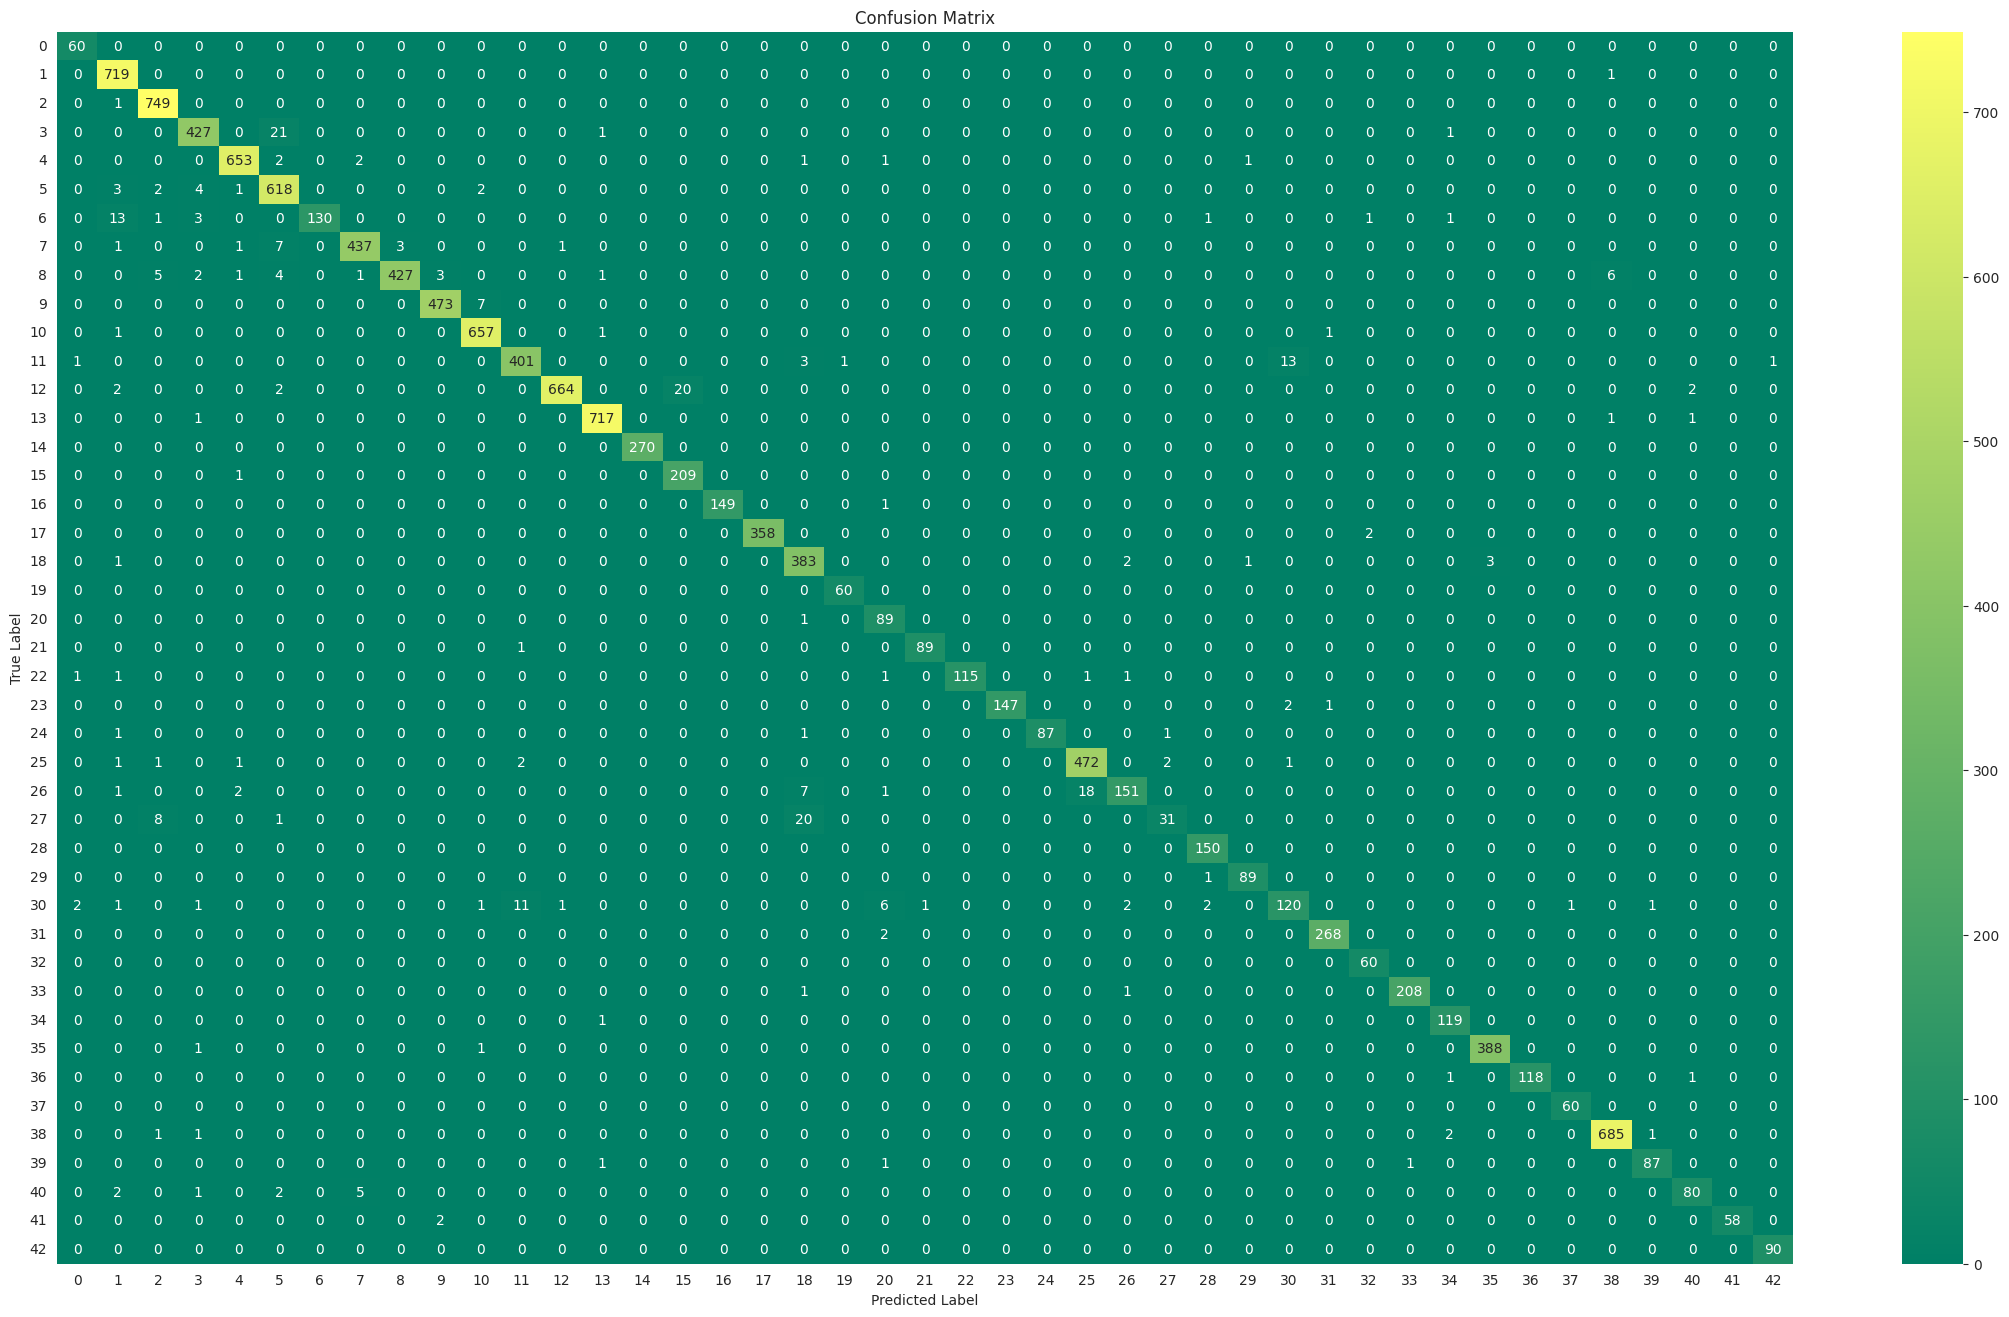

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class'])

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

#Train the best vgg16 model

Training the best vgg16 model on oversampled dataset.
Epoch 1/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9233 - loss: 0.3399 - val_accuracy: 0.9989 - val_loss: 0.0097
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 1.0000 - loss: 1.7833e-04 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 1.0000 - loss: 9.7224e-05 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 5/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 1.0000 - loss: 6.2252e-05 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 6/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 1.0000 - loss: 4.3428e-05 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 7/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 1.0000 - loss: 3.0440e-05 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 8/50
604/6

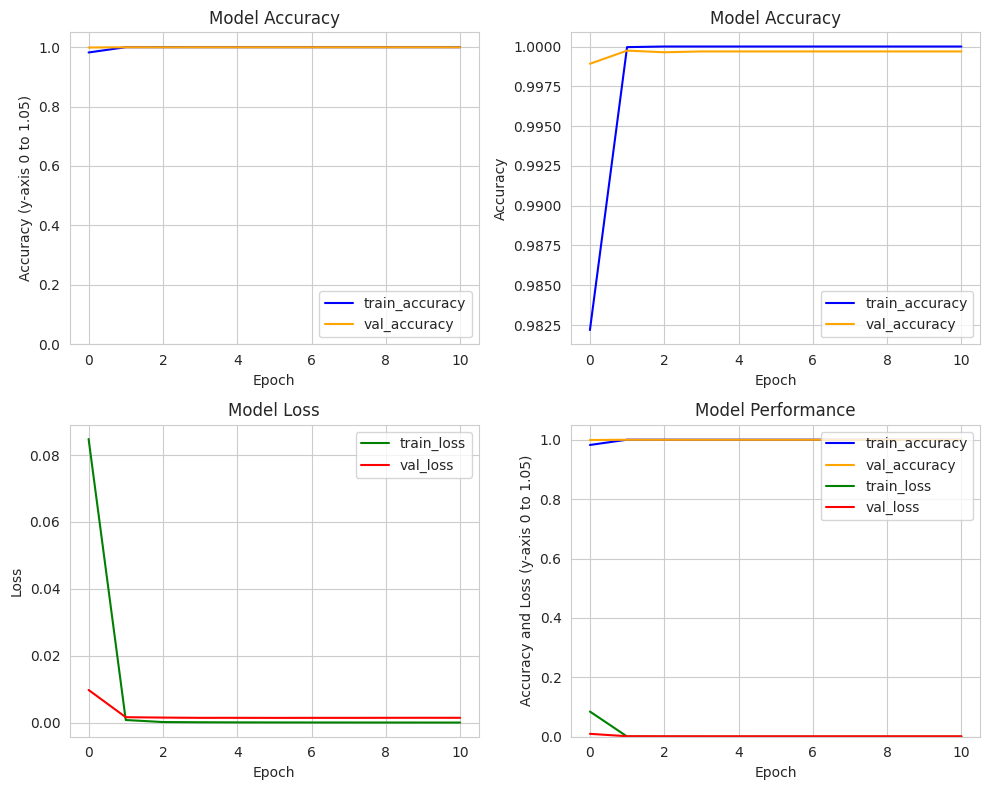

In [44]:
# Set best parameters for vgg16 model
lr = 0.001
BATCH_SIZE = 128
EPOCHS = 50

print(f'Training the best vgg16 model on oversampled dataset.')
# Call create model Function
model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

##Evaluate the model on test data (Unseen data)

In [45]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Save predicted classes and the image file names to a dataframe
predictions_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
predictions_df = predictions_df.sort_values(by='Filename')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Best vgg16 Model on oversampled dataset Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best vgg16 Model on oversampled dataset Test Accuracy: 99.06%


##Classification report

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:\n", classification_report(merged_df['ClassId'], merged_df['Predicted Class']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class']))

# Get the classification report as a dictionary
report_dict = classification_report(merged_df['ClassId'], merged_df['Predicted Class'], output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_vgg16_oversampled.csv', index=True)

# Save the model
model.save("best_vgg16_oversampled.h5")

print("Classification report saved as 'classification_report_vgg16_oversampled.csv'")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      0.99      1.00       750
           3       0.99      0.97      0.98       450
           4       1.00      1.00      1.00       660
           5       0.98      1.00      0.99       630
           6       1.00      0.96      0.98       150
           7       1.00      1.00      1.00       450
           8       0.99      1.00      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       0.97      1.00      0.98       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.95      1.00      0.97       210
          16       1.00      1.00      1.00       150
   

##Confusion Matrix

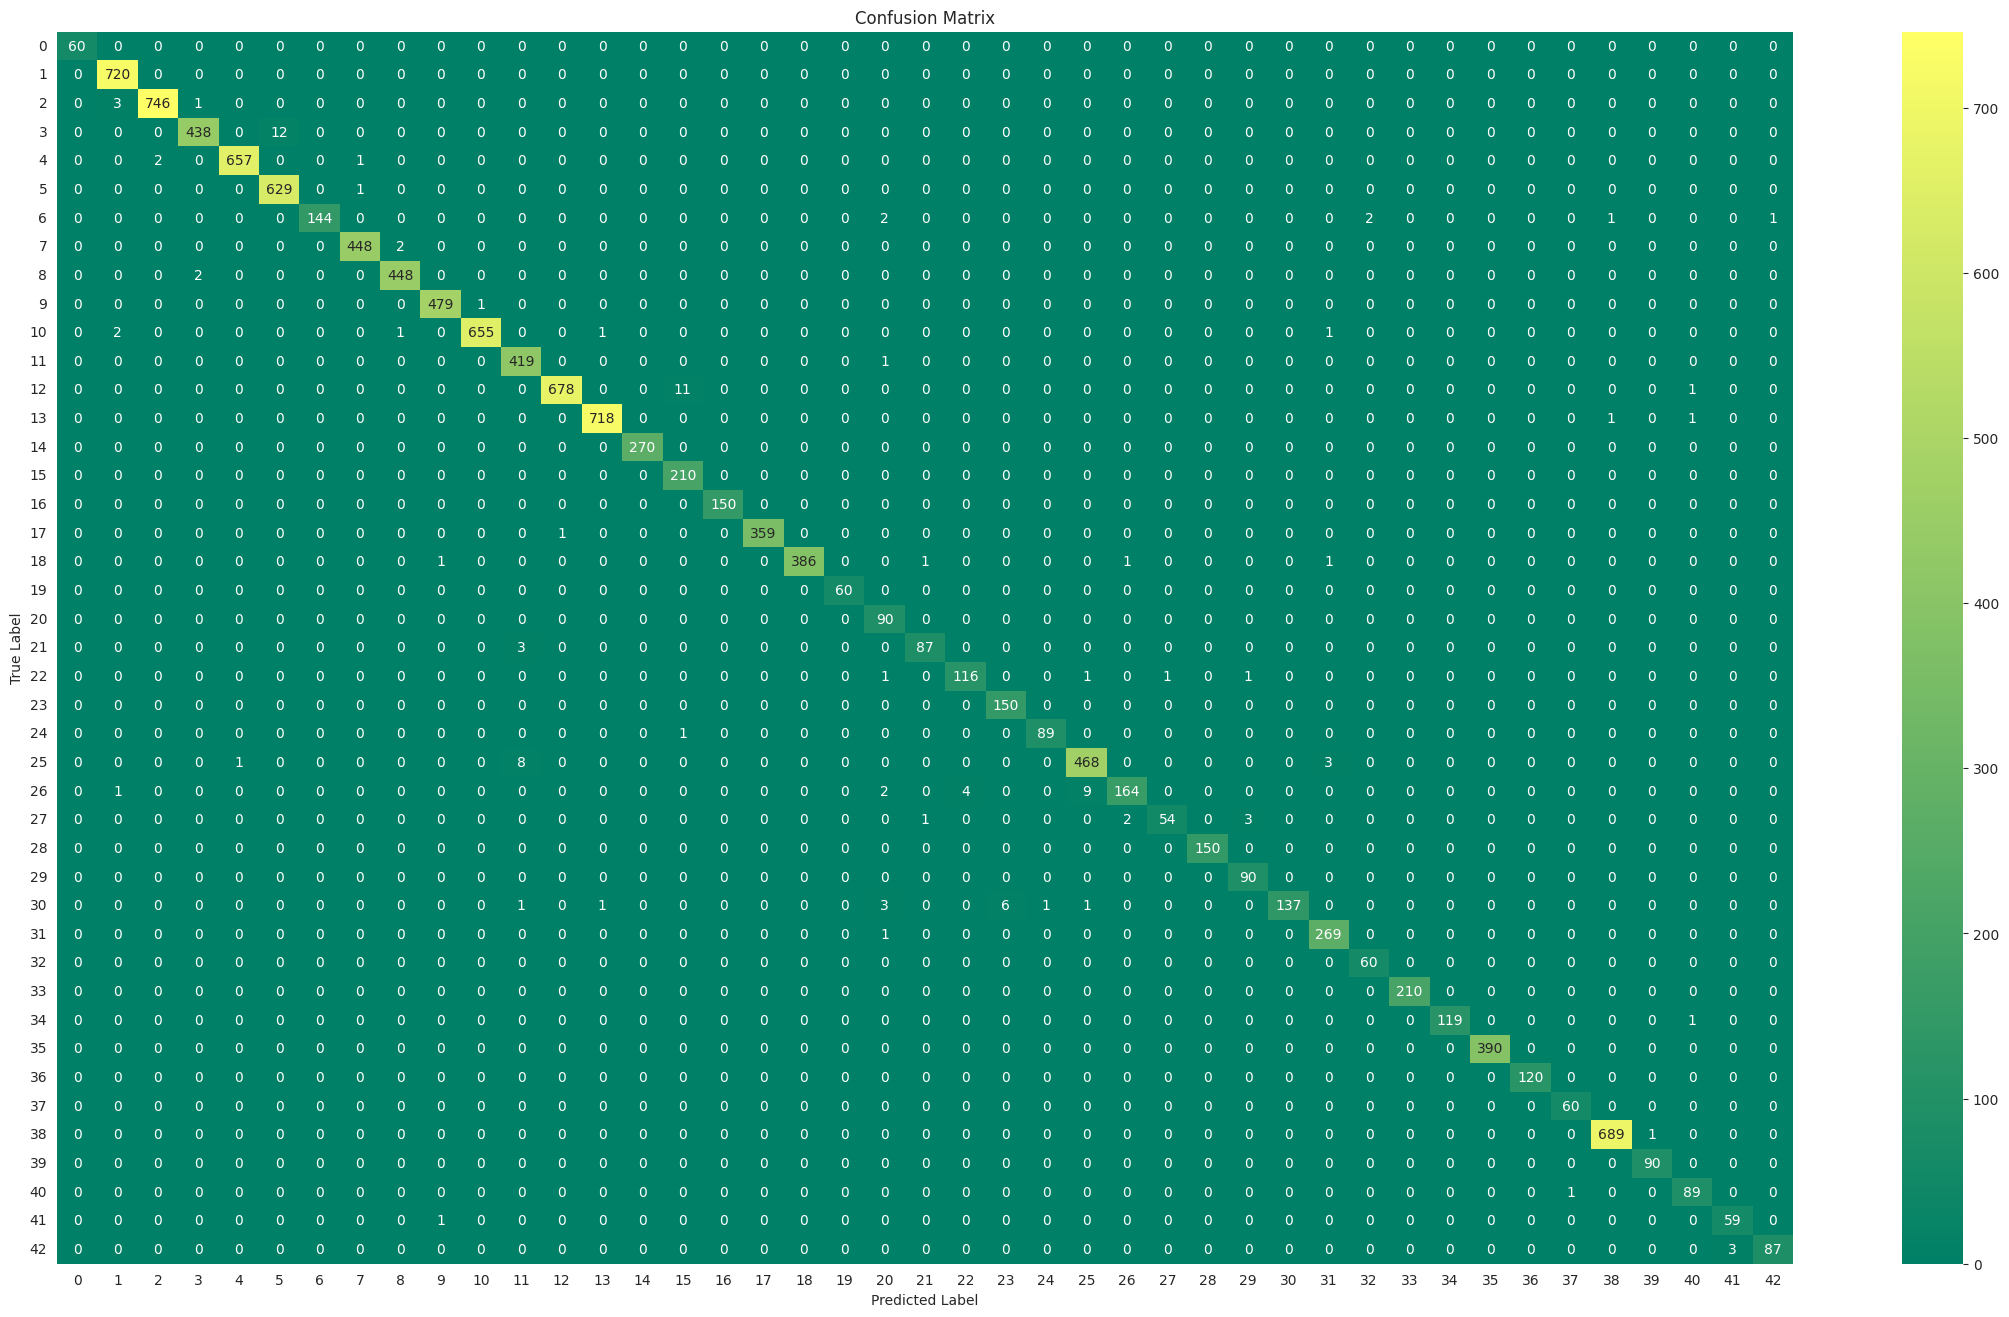

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class'])

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

#Train the best ResNet50 model

Training the best ResNet50 model on oversampled dataset.
Epoch 1/50
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9112 - loss: 0.4289 - val_accuracy: 0.9981 - val_loss: 0.0131
Epoch 2/50
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9993 - loss: 0.0071 - val_accuracy: 0.9978 - val_loss: 0.0117
Epoch 3/50
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.9984 - val_loss: 0.0070
Epoch 4/50
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9993 - val_loss: 0.0031
Epoch 5/50
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9995 - val_loss: 0.0027
Epoch 6/50
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 1.0000 - loss: 2.1756e-04 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 7/50
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 1.0000 - loss: 6.5617e-05 - val_accuracy: 0.9991 - val_loss: 0.0052
Epoch 8/50
2418/2

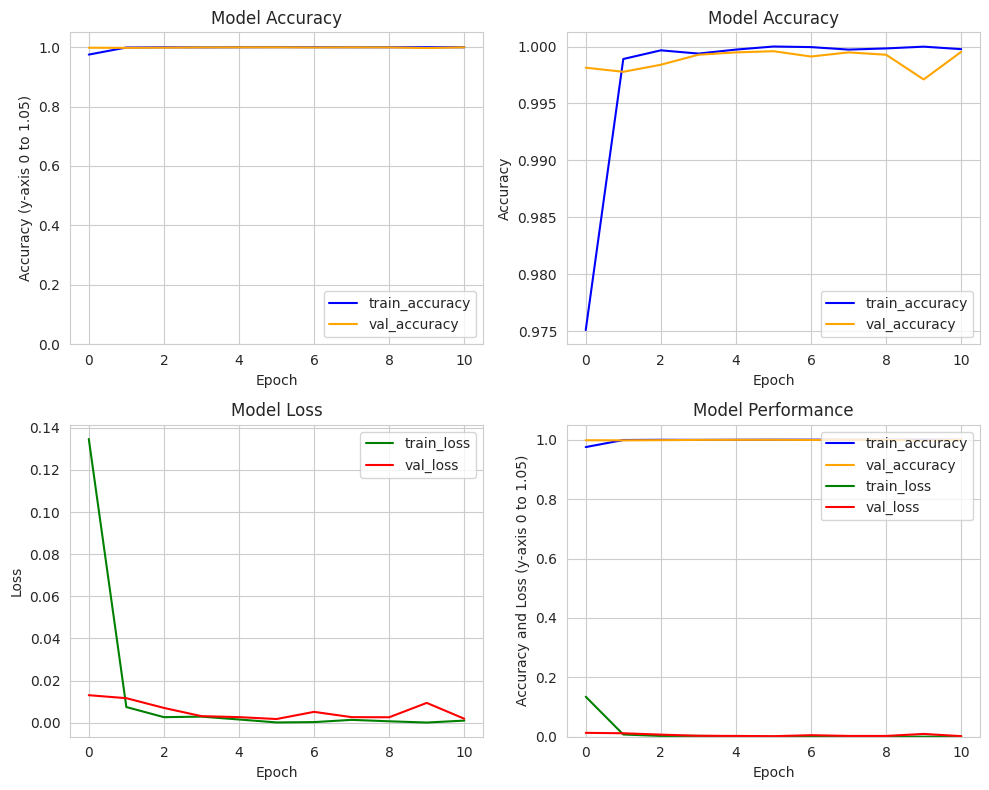

In [36]:
# Set best parameters
lr = 0.0001
BATCH_SIZE = 32
EPOCHS = 50

print(f'Training the best ResNet50 model on oversampled dataset.')
# Call create model Function
model = load_ResNet50_model_8_conv_layer((IMG_SIZE,IMG_SIZE, 3))

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

##Evaluate the model on test data (Unseen data)

In [37]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Save predicted classes and the image file names to a dataframe
predictions_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
predictions_df = predictions_df.sort_values(by='Filename')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Best ResNet50 Model on oversampled dataset Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Best ResNet50 Model on oversampled dataset Test Accuracy: 97.28%


##Classification report

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:\n", classification_report(merged_df['ClassId'], merged_df['Predicted Class']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class']))

# Get the classification report as a dictionary
report_dict = classification_report(merged_df['ClassId'], merged_df['Predicted Class'], output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_ResNet50_oversampled.csv', index=True)

# Save the model
model.save("best_resnet50_oversampled.h5")

print("Classification report saved as 'classification_report_ResNet50_oversampled.csv'")

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93        60
           1       0.96      0.99      0.97       720
           2       0.99      0.99      0.99       750
           3       0.98      0.96      0.97       450
           4       0.99      0.98      0.99       660
           5       0.95      0.99      0.97       630
           6       1.00      0.89      0.94       150
           7       0.99      0.95      0.97       450
           8       0.93      0.96      0.95       450
           9       0.98      1.00      0.99       480
          10       1.00      0.99      1.00       660
          11       0.95      0.97      0.96       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       0.99      0.99      0.99       150
   

##Confusion Matrix

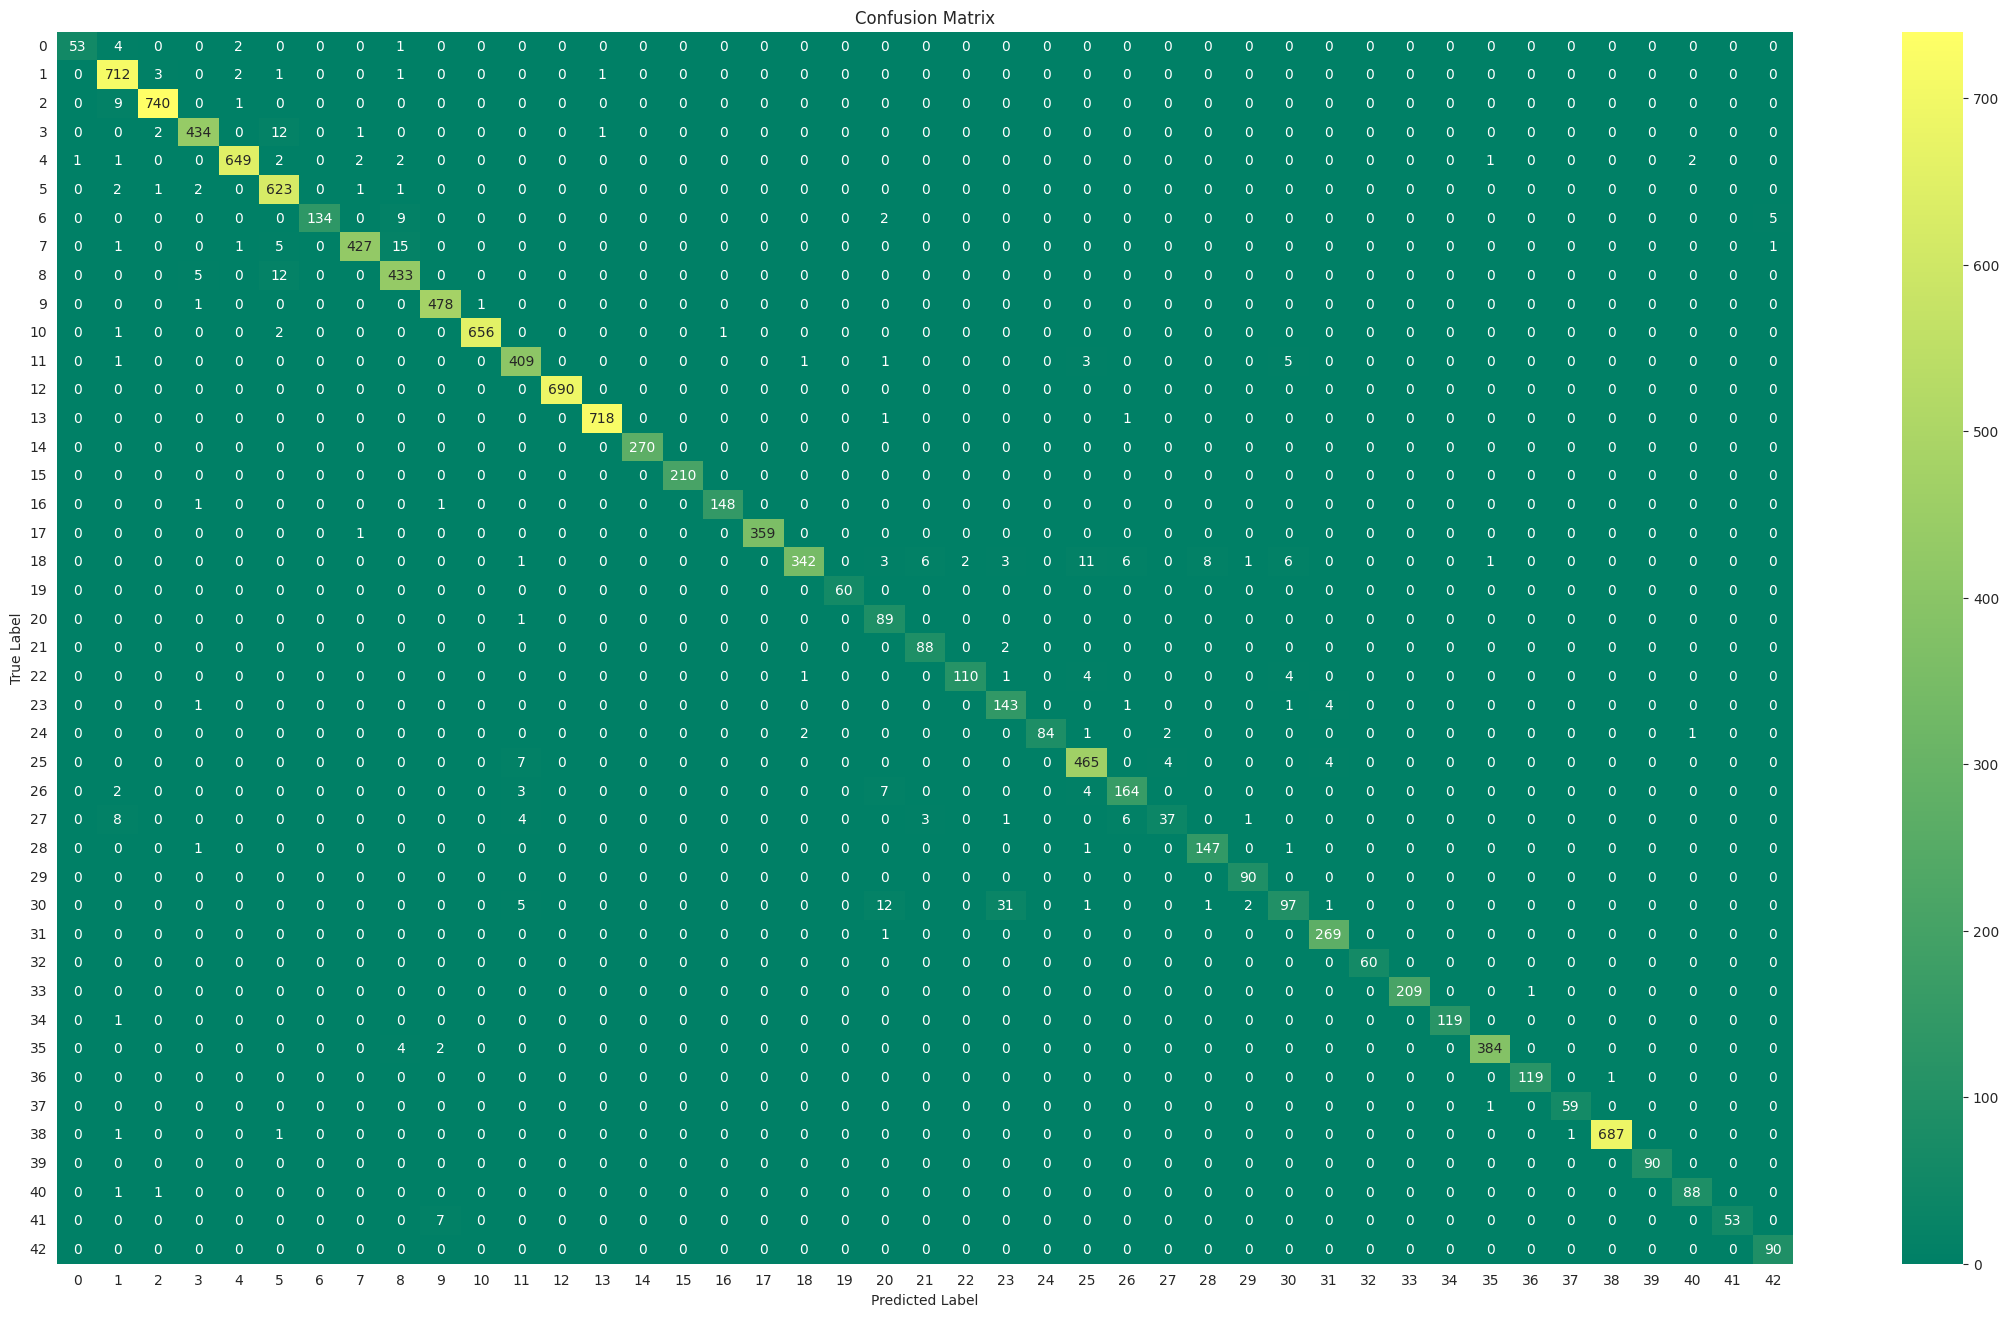

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class'])

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

#Train the best EfficientNetB0 model

Training the best EfficientNetB0 model on oversampled dataset.
Epoch 1/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.8253 - loss: 0.8094 - val_accuracy: 0.9220 - val_loss: 0.3244
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9987 - loss: 0.0113 - val_accuracy: 0.9991 - val_loss: 0.0061
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9998 - loss: 0.0033 - val_accuracy: 0.9980 - val_loss: 0.0072
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9982 - val_loss: 0.0077
Epoch 5/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9982 - val_loss: 0.0083
Epoch 6/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9984 - val_loss: 0.0069
Epoch 7/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9995 - val_loss: 0.0025
Epoch 8/50
604/604 ━━━━━━━━━━━━━

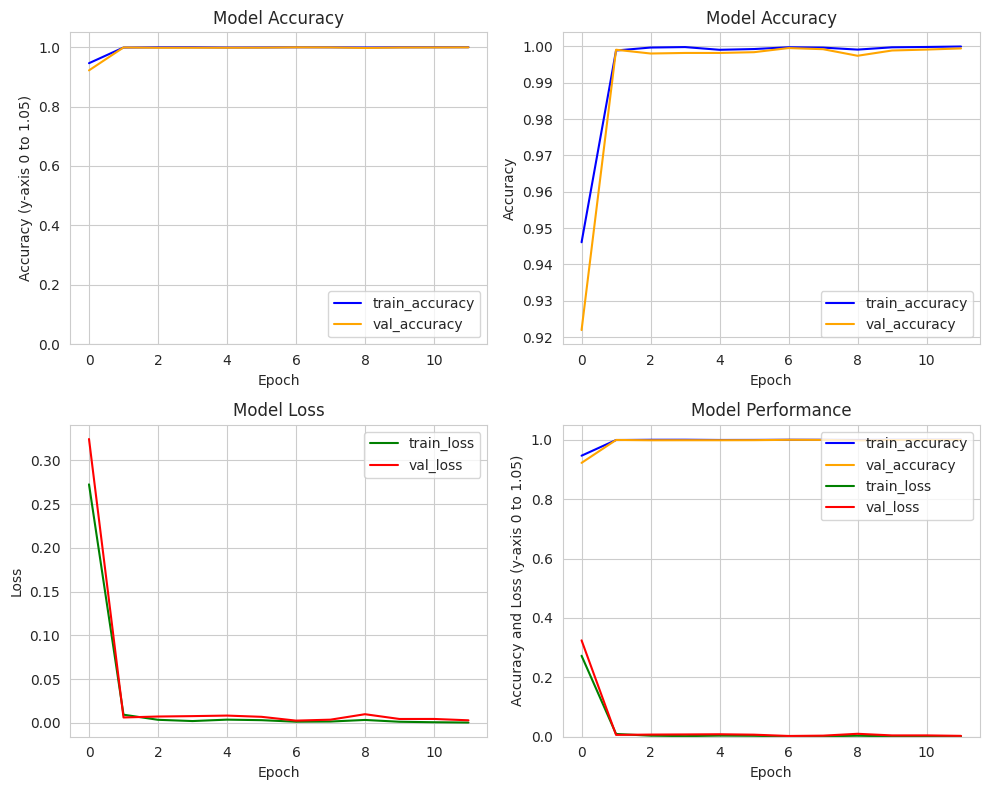

In [40]:
# Set best parameters
lr = 0.001
BATCH_SIZE = 128
EPOCHS = 50

print(f'Training the best EfficientNetB0 model on oversampled dataset.')
# Call create model Function
model = load_EfficientNetB0_model_block3a_project_conv((IMG_SIZE,IMG_SIZE, 3))

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

##Evaluate the model on test data (Unseen data)

In [41]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Save predicted classes and the image file names to a dataframe
predictions_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
predictions_df = predictions_df.sort_values(by='Filename')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Best EfficientNetB0 Model on oversampled dataset Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Best EfficientNetB0 Model on oversampled dataset Test Accuracy: 98.03%


##Classification report

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:\n", classification_report(merged_df['ClassId'], merged_df['Predicted Class']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class']))

# Get the classification report as a dictionary
report_dict = classification_report(merged_df['ClassId'], merged_df['Predicted Class'], output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_EfficientNetB0_oversampled.csv', index=True)

# Save the model
model.save("best_efficientnetb0_oversampled.h5")

print("Classification report saved as 'classification_report_EfficientNetB0_oversampled.csv'")

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        60
           1       0.96      0.99      0.97       720
           2       0.99      0.99      0.99       750
           3       0.99      0.96      0.97       450
           4       0.99      0.99      0.99       660
           5       0.97      0.98      0.98       630
           6       1.00      0.92      0.96       150
           7       0.98      0.96      0.97       450
           8       0.96      0.99      0.98       450
           9       0.97      1.00      0.99       480
          10       0.99      1.00      1.00       660
          11       0.96      0.97      0.97       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      0.99      1.00       150
   

##Confusion Matrix

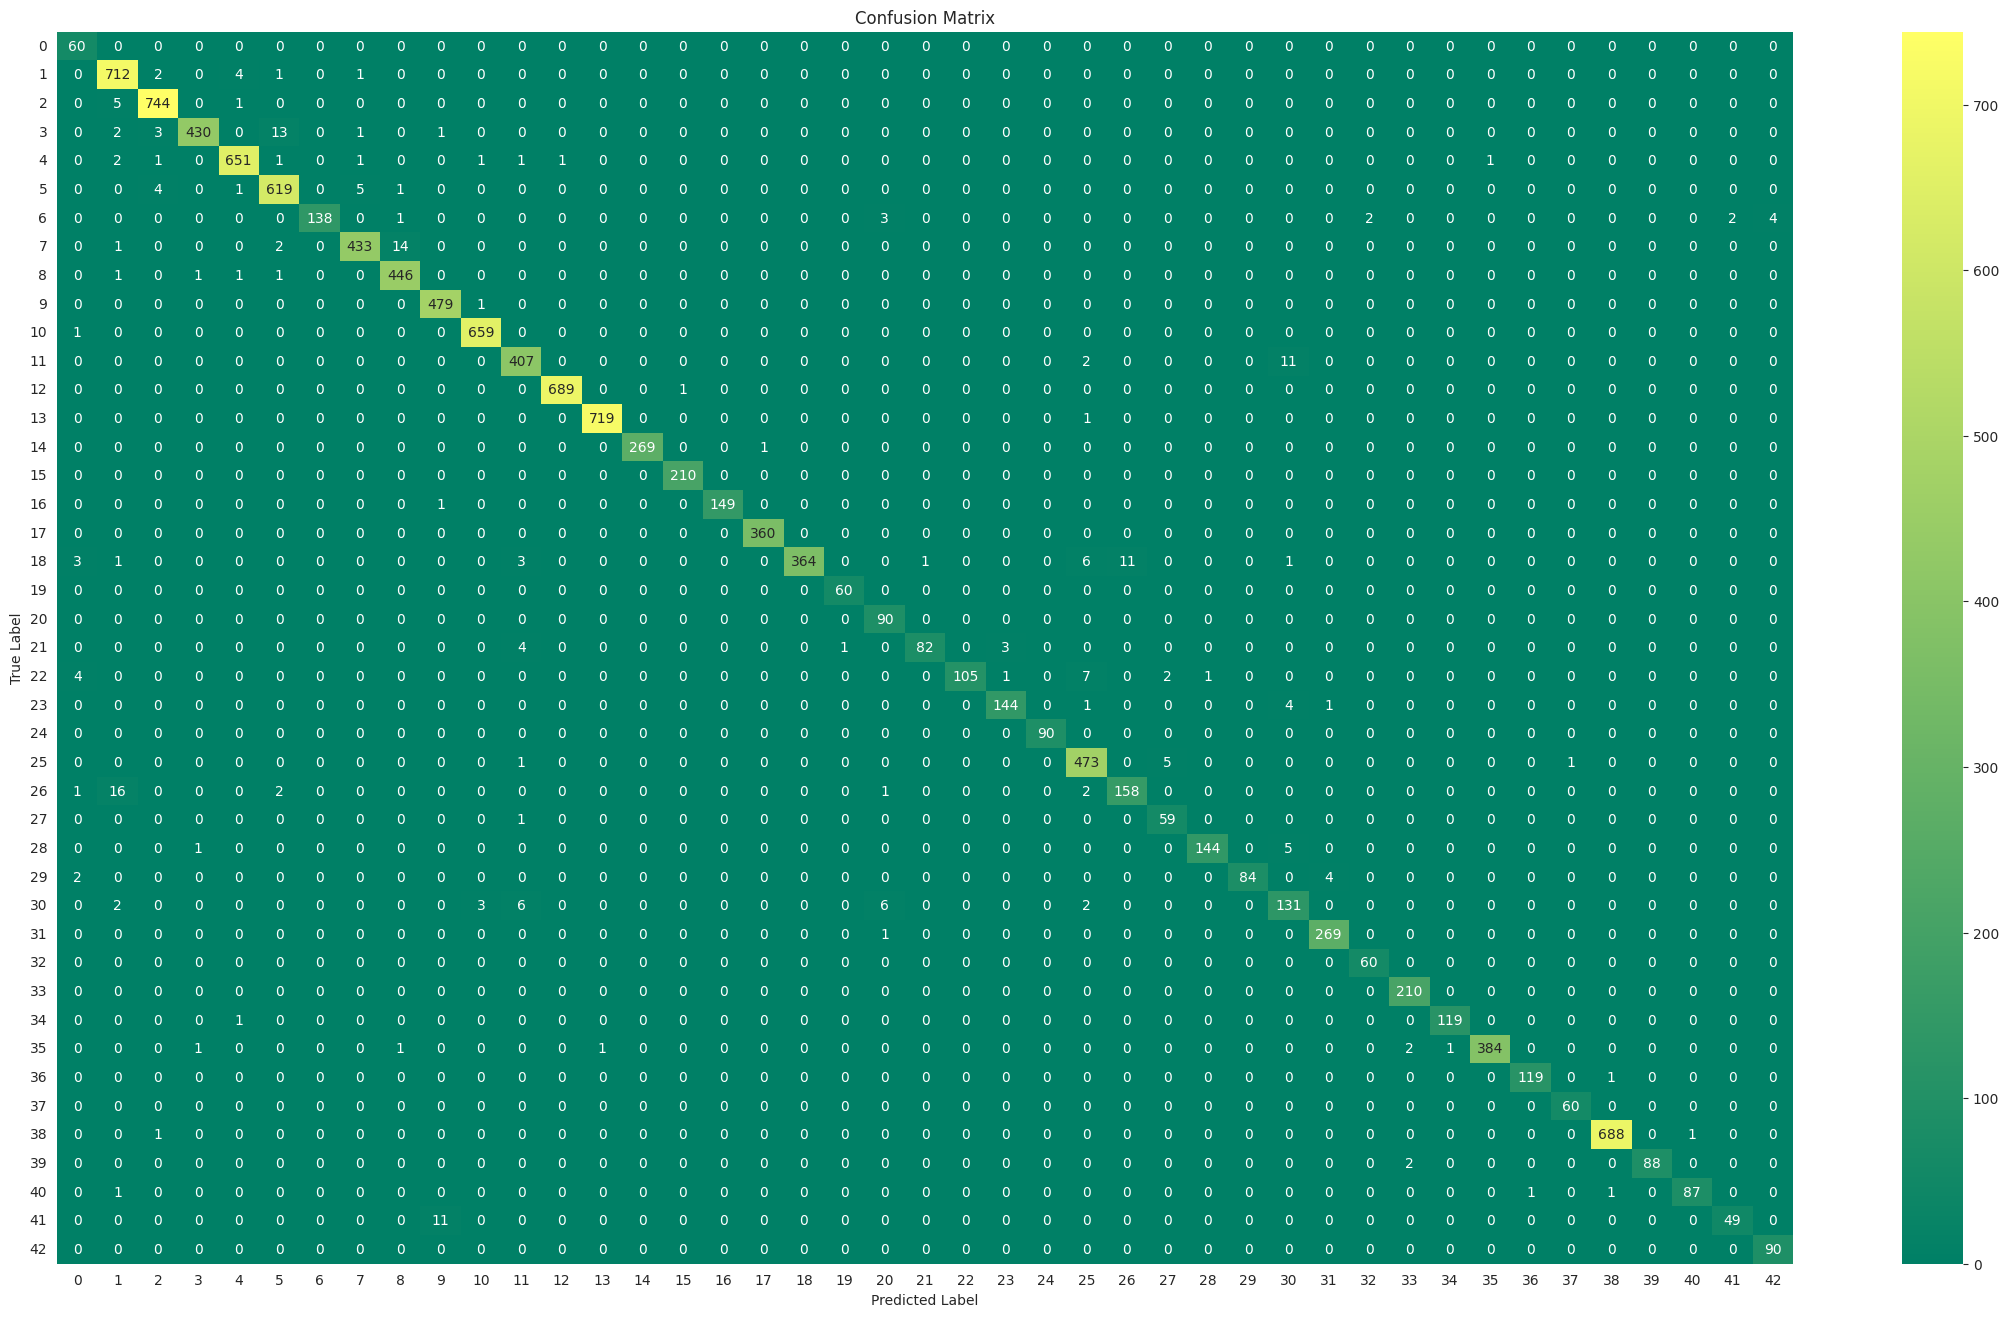

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_df['ClassId'], merged_df['Predicted Class'])

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

#Conclusion